In [6]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

In [7]:
### common parameters
agnetsCount = 1000
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.005), np.arange(0.1, 1, 0.05)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1, 0.05), np.arange(1, 2.1, 0.5)
])

class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
speedV = 3

targetPath = "lastState.h5"  # lastStateAfter  # lastStateRing  # lastState

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalPointTheta = totalPointTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.concatenate([
    np.random.uniform(1, 3, size=500),
    np.random.uniform(-3, -1, size=500)
])

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

def plot_last_state(key: str, ax: plt.Axes = None, loadModel: bool = False,
                    showTicks: bool = False, tickSize: int = 16, randomSeed: int = 10):
    if ax is None:

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    if loadModel:
        l, d0 = key.split("_")
        l, d0 = float(l), float(d0)
        model = SpatialGroups(l, d0, speedV, savePath="./data", randomSeed=randomSeed)
        sa = StateAnalysis(model, showTqdm=False)
        singlePositionX, singlePhaseTheta, _ = sa.get_state(-1)
    else:
        singlePositionX = positionX[key]
        singlePhaseTheta = phaseTheta[key]
    alphaRate = 0.9
    np.random.seed(10)
    omegaTheta = np.concatenate([
        np.random.uniform(1, 3, size=500),
        np.random.uniform(-3, -1, size=500)
    ])
    scale = 35
    width = 0.003
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', 
        alpha = (1 - alphaRate) + (np.abs(omegaTheta[class1]) - 1) / 2 * alphaRate,
        scale=scale, width=width
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='#414CC7', 
        alpha = (1 - alphaRate) + (np.abs(omegaTheta[class2]) - 1) / 2 * alphaRate,
        scale=scale, width=width
    )

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if showTicks:
        ax.set_xticks([0, 10])
        ax.set_yticks([0, 10])
        ax.set_xlabel(r"$x$", fontsize=tickSize)
        ax.set_ylabel(r"$y$", fontsize=tickSize, rotation=0)
        ax.set_xticklabels(ax.get_xticks(), fontsize=tickSize)
        ax.set_yticklabels(ax.get_yticks(), fontsize=tickSize)
        # 拉近label与坐标轴的距离
        ax.xaxis.labelpad = -20
        ax.yaxis.labelpad = -10
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # ax.text(0.3, 9.2, "A", fontsize=20)
    # ax.text(9.2, 9.2, "B", fontsize=20)
    # ax.text(9.2, 0.3, "C", fontsize=20)
    # ax.text(0.3, 0.3, "D", fontsize=20)
    plt.tick_params(direction='in', length=3)

def plot_centers(self: StateAnalysis, ax: plt.Axes = None, index: int = -1):
    positionX, phaseTheta, pointTheta = self.get_state(index)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    quiverColors = ["#FF4B4E"] * 500 + ["#414CC7"] * 500
    ax.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta[:]), np.sin(phaseTheta[:]), color=quiverColors, alpha=1
    )
    centerColors = ["#FBDD85"] * 500 + ["#80A6E2"] * 500
    centers = self.centers
    ax.scatter(centers[:, 0], centers[:, 1], color=centerColors, s=5)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    fontsize = 20
    ax.xaxis.labelpad = -20
    ax.yaxis.labelpad = -10
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize)
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(direction='in', length=3)
    ax.set_xlabel(r"$x$", fontsize=fontsize)
    ax.set_ylabel(r"$y$", fontsize=fontsize, rotation=0)

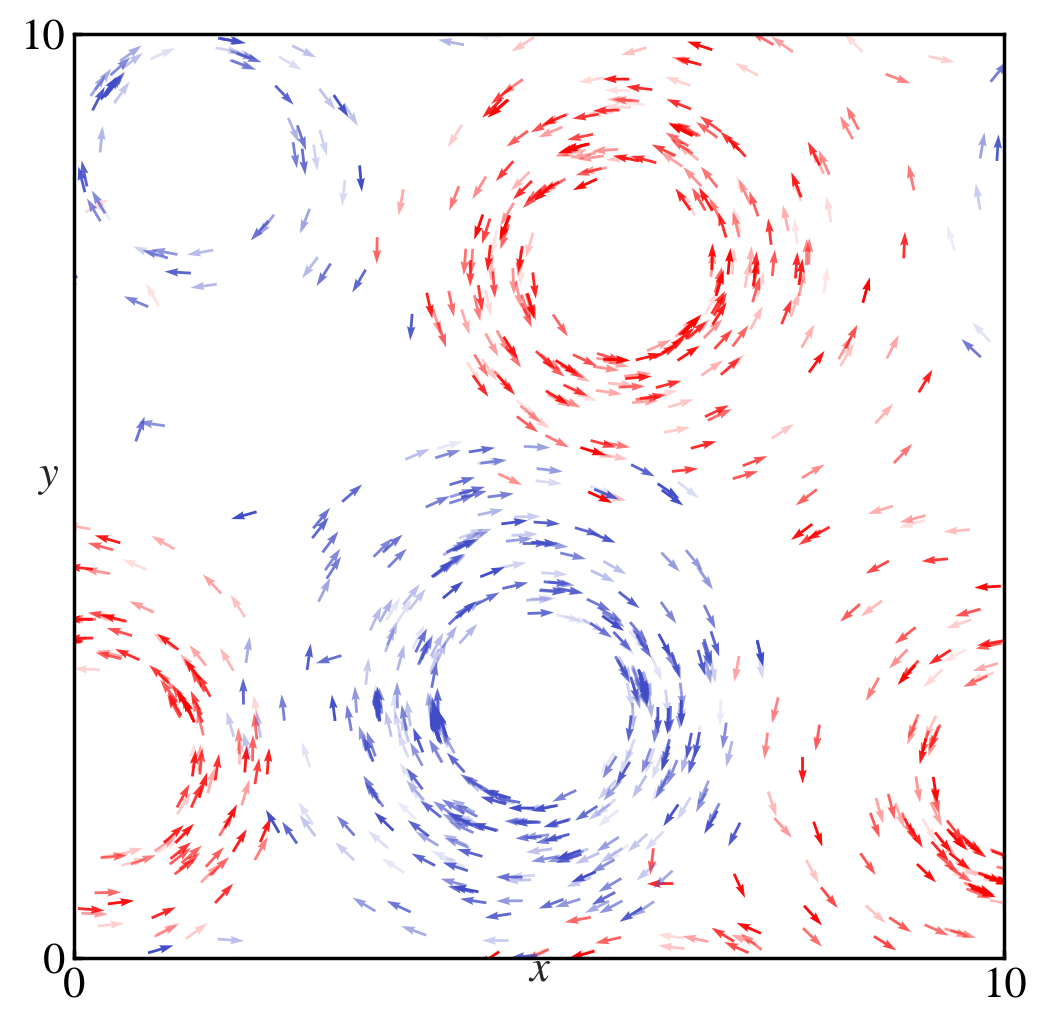

In [172]:
# plot single graphy
l, d0 = 0.08, 0.15
key = f"{l:.3f}_{d0:.2f}"
plot_last_state(key, showTicks=True)

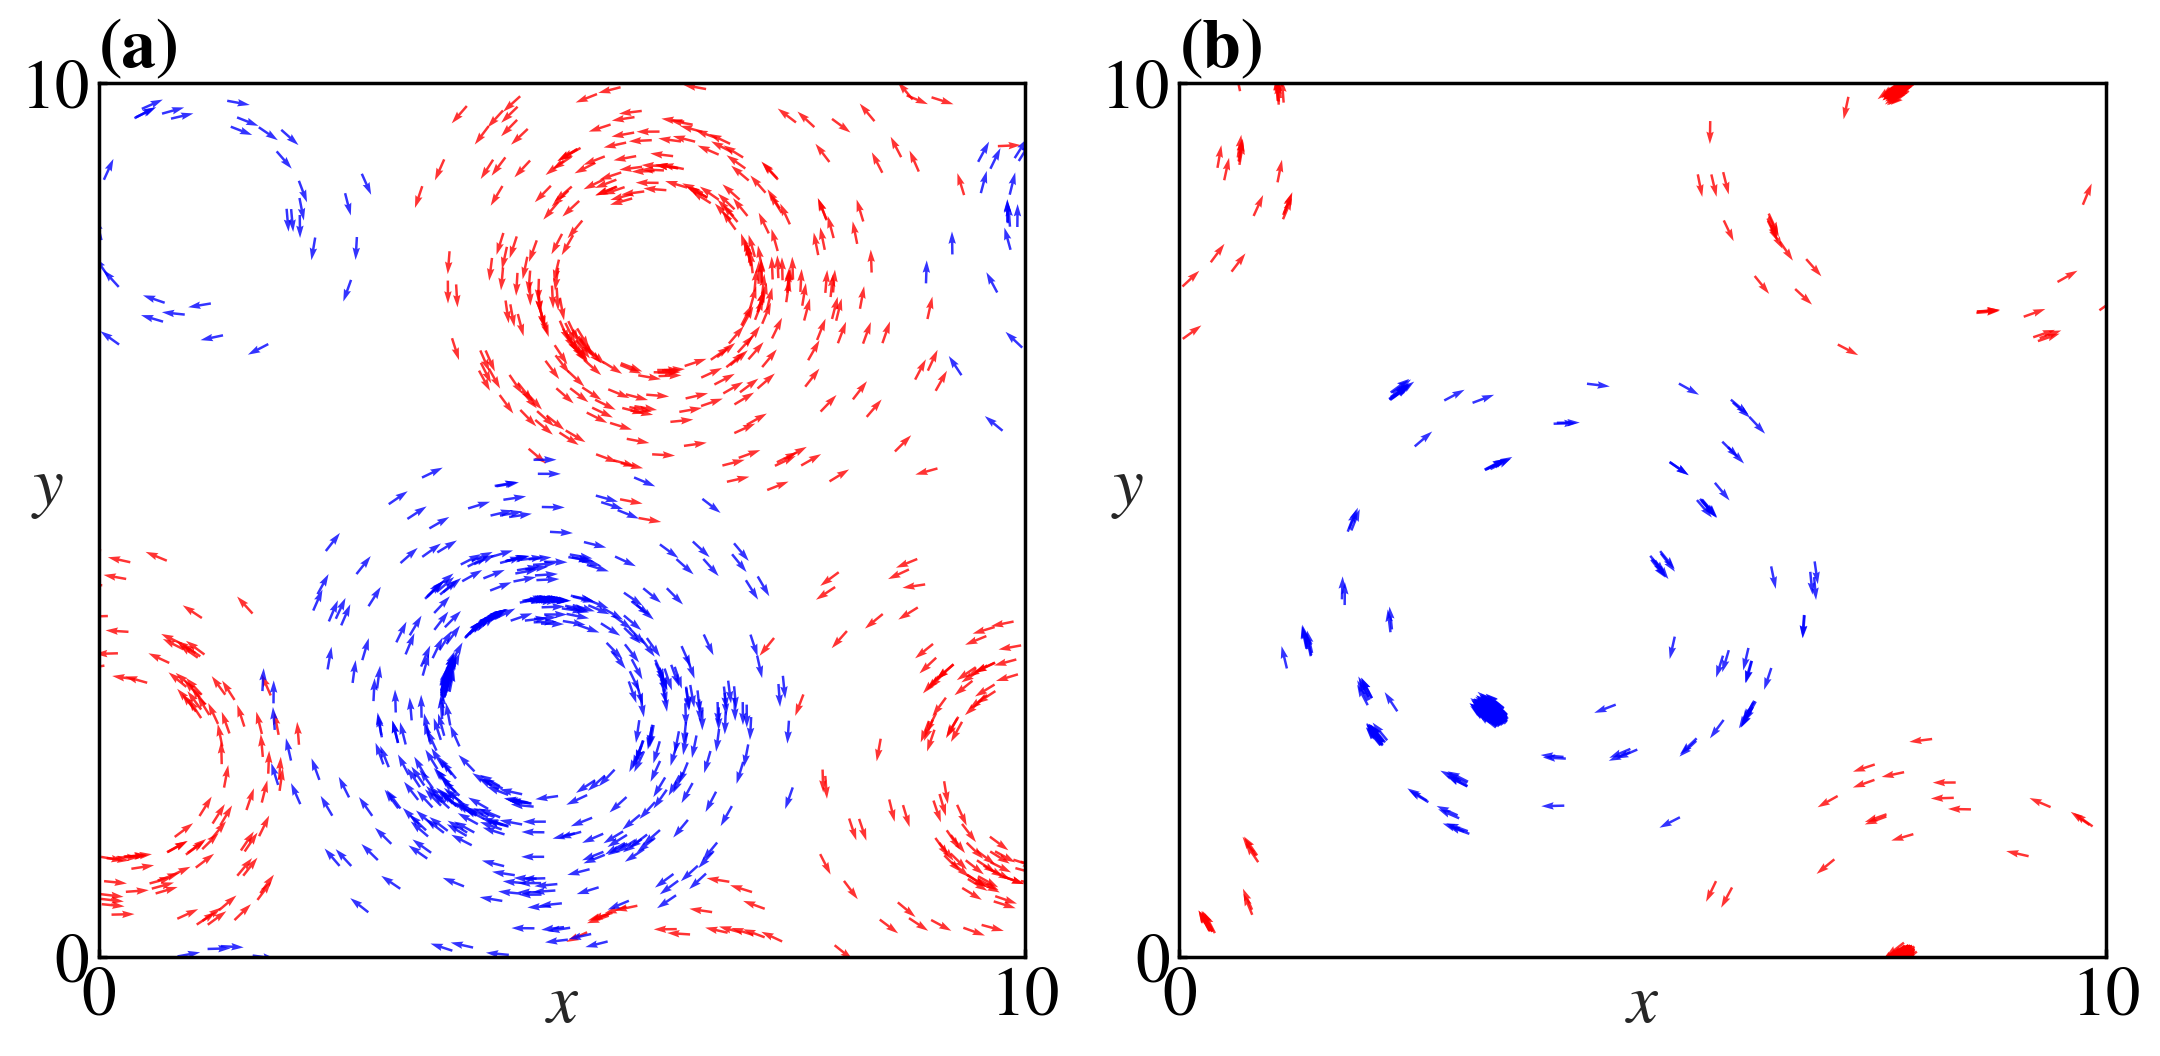

In [115]:
# plot single graphy
l, d0 = 0.015, 0.4

fig, ax = plt.subplots(1, 2, figsize=(11, 5.5))

i = 0
for l, d0 in [
    [0.015, 0.4], [0.5, 0.1]
]:

    key = f"{l:.3f}_{d0:.2f}"

    plor_last_state(key, ax=ax[i], showTicks=True, tickSize=25)
    ax[i].tick_params(direction='in', length=3)
    i += 1

ax[0].set_title("(a)", loc="left", fontweight='bold', fontsize=25)
ax[1].set_title("(b)", loc="left", fontweight='bold', fontsize=25)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/ringStateNum.pdf", bbox_inches="tight")

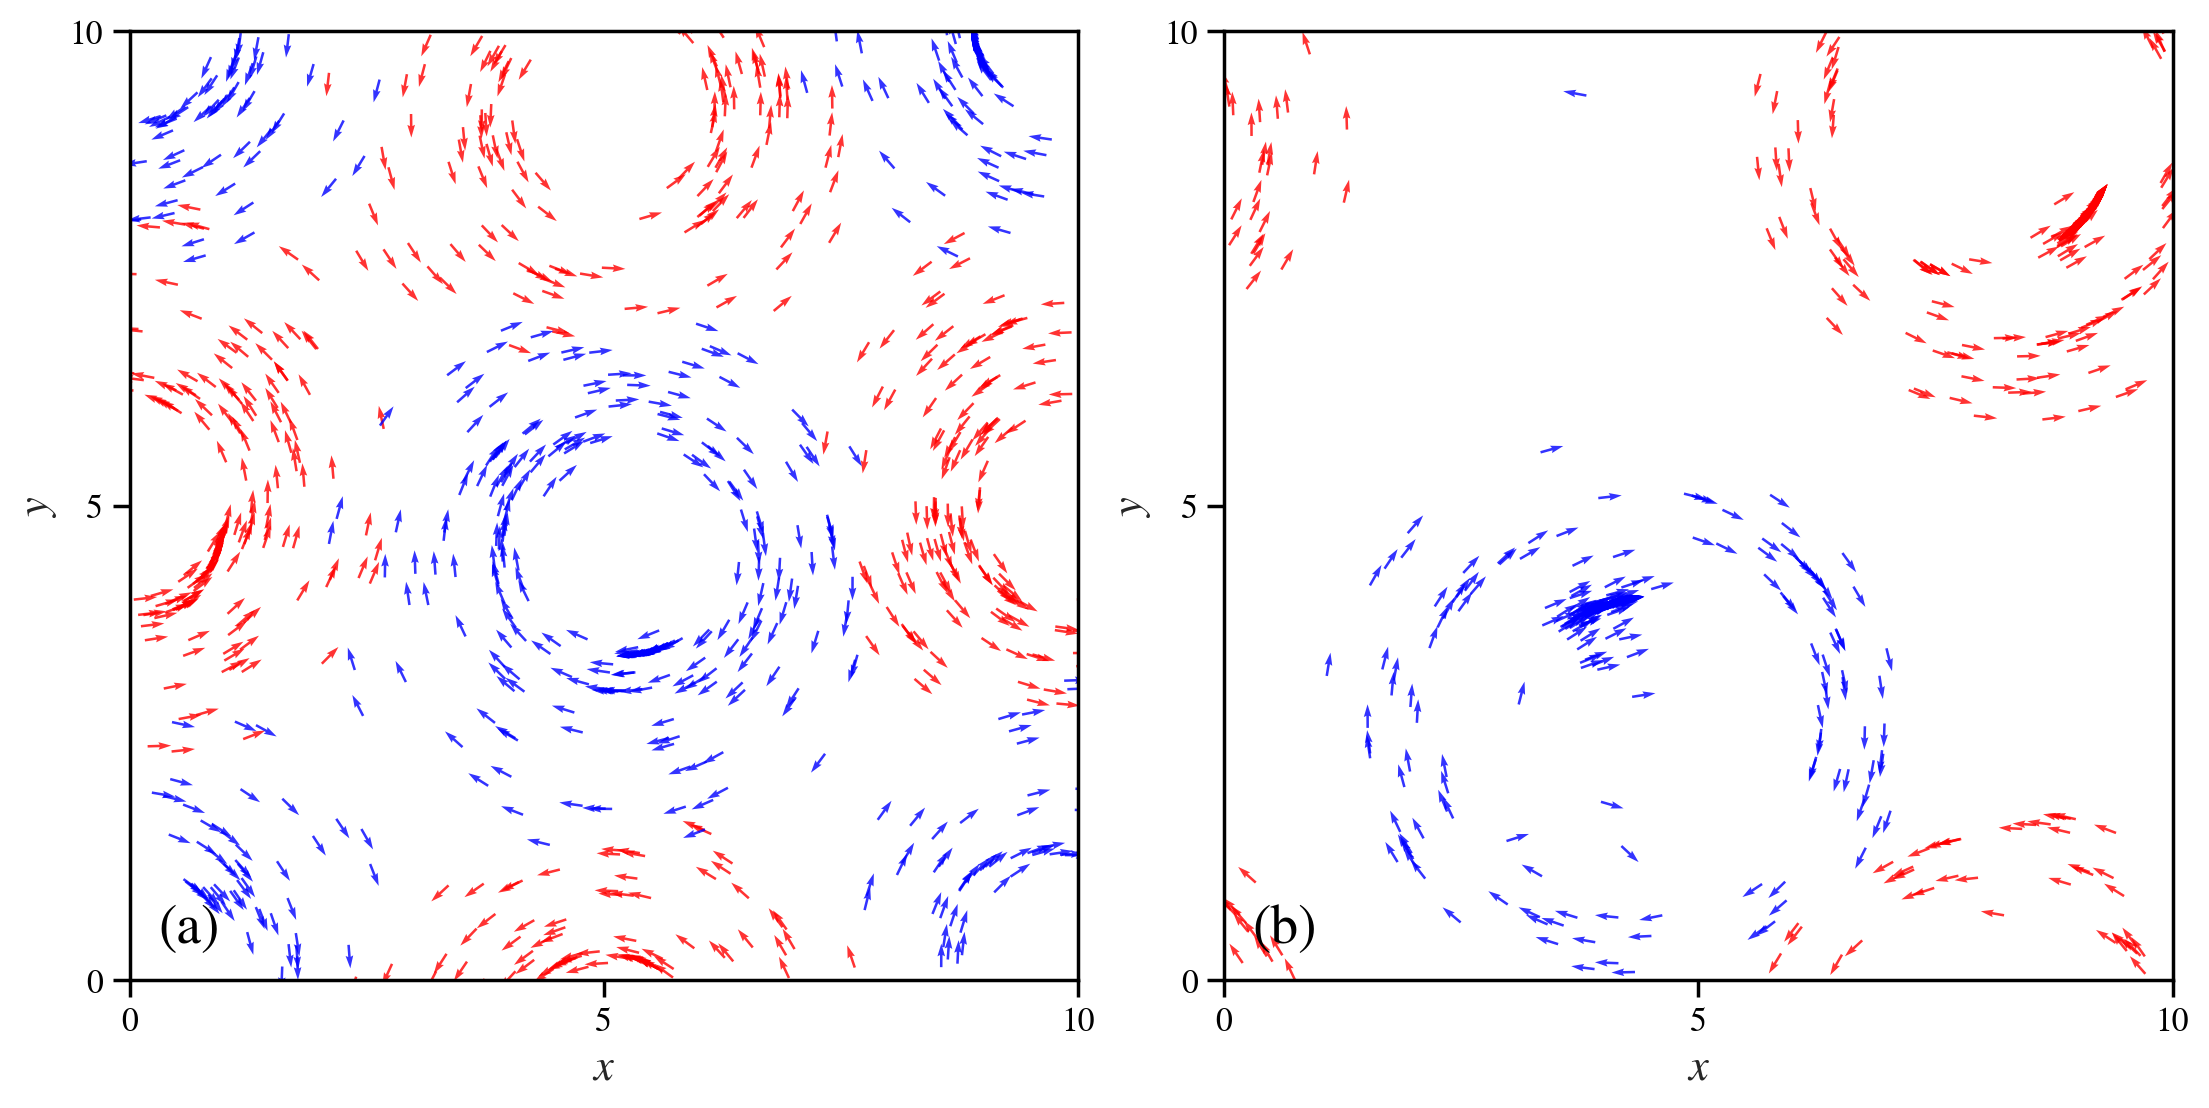

In [116]:
# plot single graphy
l, d0 = 0.015, 0.4

class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)

fig, ax = plt.subplots(1, 2, figsize=(11, 5.5))

i = 0
statesIdx = [-1, -2500]
for model in [
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, savePath="./data", randomSeed=80),
    SpatialGroups(strengthLambda=0.01, distanceD0=0.95, savePath="./data", randomSeed=10)
]:

    sa = StateAnalysis(model, showTqdm=False)
    singlePositionX, singlePhaseTheta, _ = sa.get_state(statesIdx[i])

    ax[i].quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', alpha=0.8
    )
    ax[i].quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='blue', alpha=0.8
    )

    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 10)
    ax[i].set_xticks([0, 5, 10])
    ax[i].set_yticks([0, 5, 10])
    ax[i].grid(False)
    ax[i].spines['bottom'].set_color('black')
    ax[i].spines['top'].set_color('black')
    ax[i].spines['left'].set_color('black')
    ax[i].spines['right'].set_color('black')
    if i == 0:
        ax[i].text(0.3, 0.4, r"(a)", fontsize=20)
    else:
        ax[i].text(0.3, 0.4, r"(b)", fontsize=20)
    
    ax[i].set_xlabel(r"$x$", fontsize=16)
    ax[i].set_ylabel(r"$y$", fontsize=16)

    i += 1

plt.tight_layout()

In [ ]:
# mono-chiral swarmalator
@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - (1 - (phaseTheta - 1) / 2) * 256).astype(np.int32)

rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

idx = 1

fig = plt.figure(figsize=(len(rangeLambdas) * 4.5, len(distanceDs) * 5))

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    model = SingleDistribution(strengthLambda=l, distanceD0=d0, boundaryLength=5, tqdm=False, savePath="./data", distributType="uniform", randomSeed=10, overWrite=True)
    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    
    key = f"{l:.3f}_{d0:.2f}"
    # for i in range(1, 6):
    # try:
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    # except:
    #     continue

    omegaTheta = model.omegaTheta
    plt.quiver(
        lastPositionX[:, 0], lastPositionX[:, 1],
        np.cos(lastPhaseTheta[:]), np.sin(lastPhaseTheta[:]), 
        color=[new_cmap(i) for i in colors_idx(omegaTheta)], alpha=0.8
    )
    plt.scatter(lastPositionX[:, 0], lastPositionX[:, 1],
                c=omegaTheta, cmap=new_cmap, alpha=0.8, vmin=1, vmax=3, s=0.01)

    cbar = plt.colorbar(ticks=[1, 2, 3])
    cbar.ax.set_ylim(1, 3)
    cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)    
    ax.set_title(f"{l:.3f}_{d0:.2f}")
    
    idx += 1

plt.savefig("SingleDistributionBigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

### Plot Big Graph

In [ ]:
fig = plt.figure(figsize=(len(distanceDs) * 5, len(rangeLambdas) * 5))

idx = 1

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    key = f"{l:.3f}_{d0:.2f}"

    singlePositionX = positionX[key]
    singlePhaseTheta = phaseTheta[key]
    singlePointTheta = pointTheta[key]

    # centers = StateAnalysis._calc_centers(singlePositionX, singlePhaseTheta, singlePointTheta, speedV)

    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', alpha=0.8
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='blue', alpha=0.8
    )
    # ax.scatter(centers[class1, 0], centers[class1, 1], color="orange", s=5)
    # ax.scatter(centers[class2, 0], centers[class2, 1], color="blue", s=5)
    # ax.scatter(centers[:, 0], centers[:, 1], color="green", s=3, alpha=0.7)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    ax.set_title(key)

    idx += 1

plt.tight_layout()
plt.savefig("bigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

# 旋转半径

4.982621803415039
5.0134962448963
5.0283626043579925
4.9320342663212875
4.792685087950748
4.774855126469589


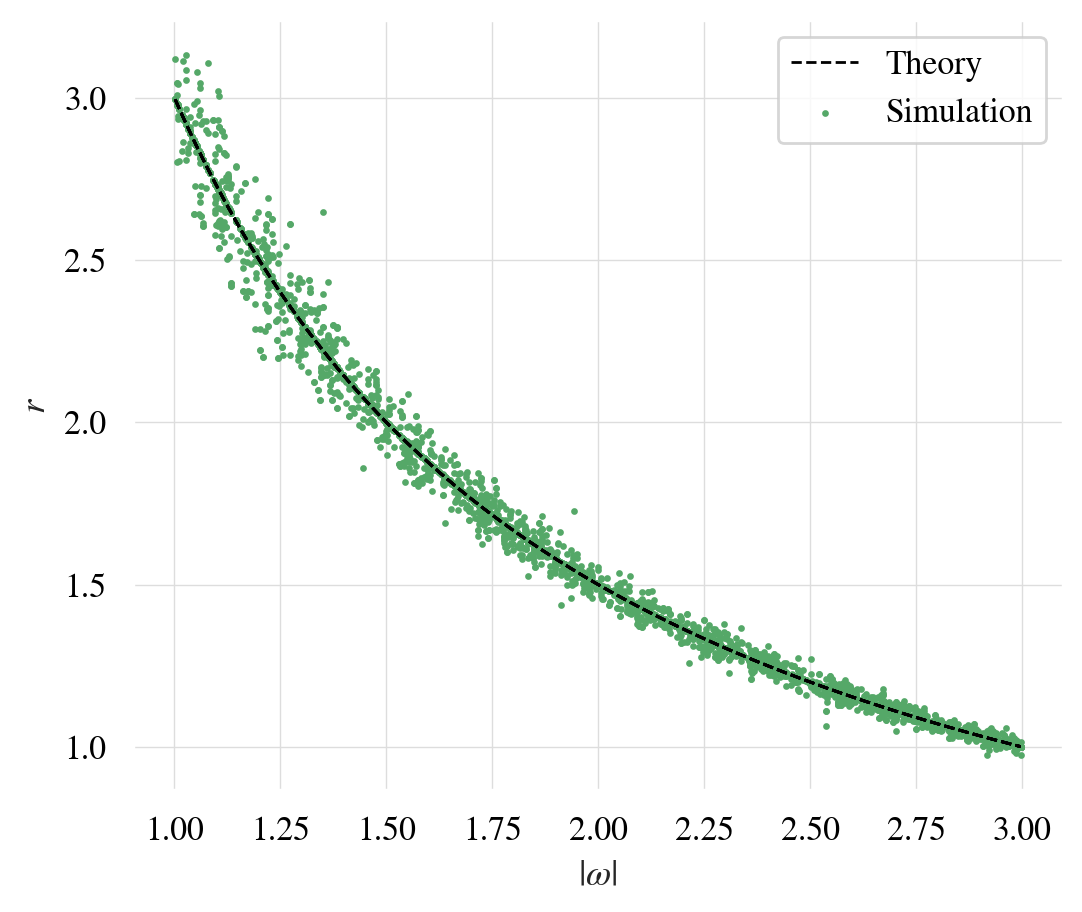

In [21]:
rangeLambdas = np.concatenate([
    np.arange(0.04, 0.1, 0.01)
])
distanceDs = [0.1]
legend = True

for rangeLambda in rangeLambdas:
    
    model = SpatialGroups(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]
    print(lastPositionX.mean())

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    plt.scatter(omegaTheta, distances, s=2, color="C2")
    plt.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1)
    plt.xlabel(r"$\left| \omega \right|$")
    plt.ylabel(r"$r$")
    if rangeLambda == rangeLambdas[-1]:
        # legend = False
        plt.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Theory")
        plt.scatter(omegaTheta, distances, label="Simulation", s=2, color="C2")
        plt.legend()
# plt.legend(["Theory", "Simulation"])

In [5]:
model = SingleDistribution(
    strengthLambda=0, distanceD0=0, boundaryLength=5, 
    tqdm=True, savePath="./data", distributType="uniform", randomSeed=10, overWrite=False
)
# model.run(500)

Text(0, 0.5, '$r$')

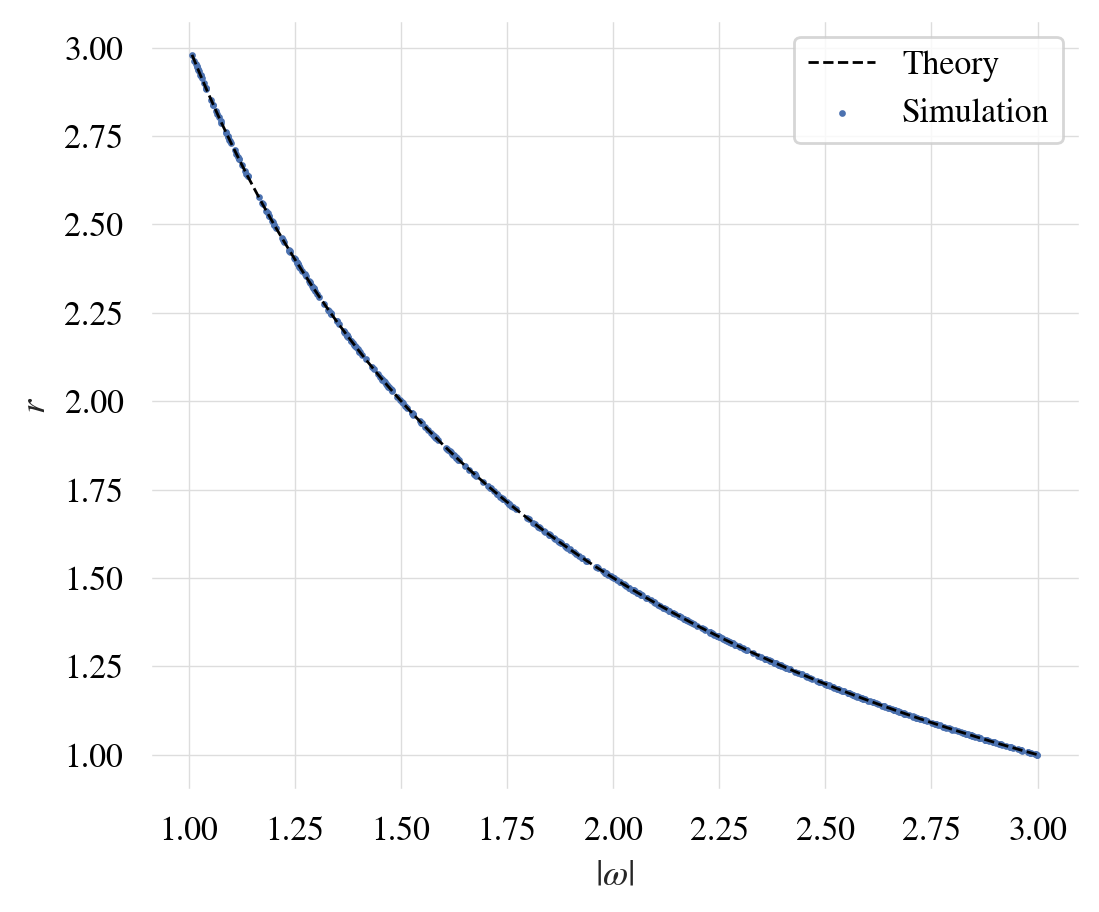

In [8]:
sa = StateAnalysis(model, lookIndex=-1, showTqdm=False)
centers = sa.centersNoMod
positionX, phaseTheta, pointTheta = sa.get_state(-1)
distances = np.sqrt(np.sum((centers - positionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
omegaTheta = model.omegaTheta
sort = np.argsort(omegaTheta)
omegaTheta, distances = omegaTheta[sort], distances[sort]

plt.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Theory")
plt.scatter(omegaTheta, distances, label="Simulation", s=2)
plt.legend()
plt.xlabel(r"$\left| \omega \right|$")
plt.ylabel(r"$r$")

# 序参量

In [9]:
maps = pd.read_excel("maps.xlsx", index_col=0)

def lambda_c1(d0):
    rs = 3
    N = 1000 / 4
    rho = N / (np.pi * (3**2 - 1**2))
    deltaOmega = 2 / N
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    Si = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
    sigmaA = Si * rho
    return deltaOmega / sigmaA

def lambda_c2(d0):
    rs = 1
    deltaOmega = 2
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    N = 500
    return (
        np.pi * rs ** 2 * deltaOmega
        / (N - 1)
        / (alpha * d0**2 / 2 + beta * rs**2 / 2 - rs * d0 * np.sin(alpha / 2))
    )

def lambda_c3(d0):
    L = 10
    deltaOmega = 2
    N = 1000
    return (
        deltaOmega
        / (N * np.pi * d0 ** 2 / L ** 2)
    )

def lambda_c4(d0):
    L = 10
    rc = 1.5
    rs = 1.5
    if d0 + 2 * (rc + rs) < L / np.sqrt(2):
        # print(d0 + 2 * (rc + rs), L / np.sqrt(2))
        return np.inf
    deltaOmega = 6
    N = 500
    rh = L / np.sqrt(2) - 2 * (rc + rs)
    rd = rh + rs
    beta = 2 * np.arccos((d0 ** 2 + rd ** 2 - rs ** 2) / (2 * d0 * rd))
    alpha = 2 * np.arccos((rd ** 2 + rs ** 2 - d0 ** 2) / (2 * rd * rs))
    si = alpha * rs ** 2 / 2 + beta * d0 ** 2 / 2 - d0 * rd * np.sin(beta / 2)
    Ni = N * si / (np.pi * rs ** 2)
    return deltaOmega / Ni

def lambda_c5(d0):
    rs = 3
    N = 1000 / 10
    rho = N / (np.pi * (3**2 - 1**2))
    deltaOmega = 2 / N
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    Si = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
    sigmaA = Si * rho
    return deltaOmega / sigmaA

funcIdxs = dict()
for func in [lambda_c1, lambda_c2, lambda_c3, lambda_c4, lambda_c5]:
    funcIdxs[func] = []
    for d0 in maps.columns:
        l = func(d0)
        idx = 0
        upper = maps.index[maps.index > l].min()
        if np.isnan(upper):
            upper = maps.index.max()
        idx = idx + np.where(maps.index == upper)[0][0]
        lower = maps.index[maps.index < l].max()
        if np.isnan(lower):
            lower = maps.index.min()
        idx = idx + np.where(maps.index == lower)[0][0]
        funcIdxs[func].append(idx / 2)

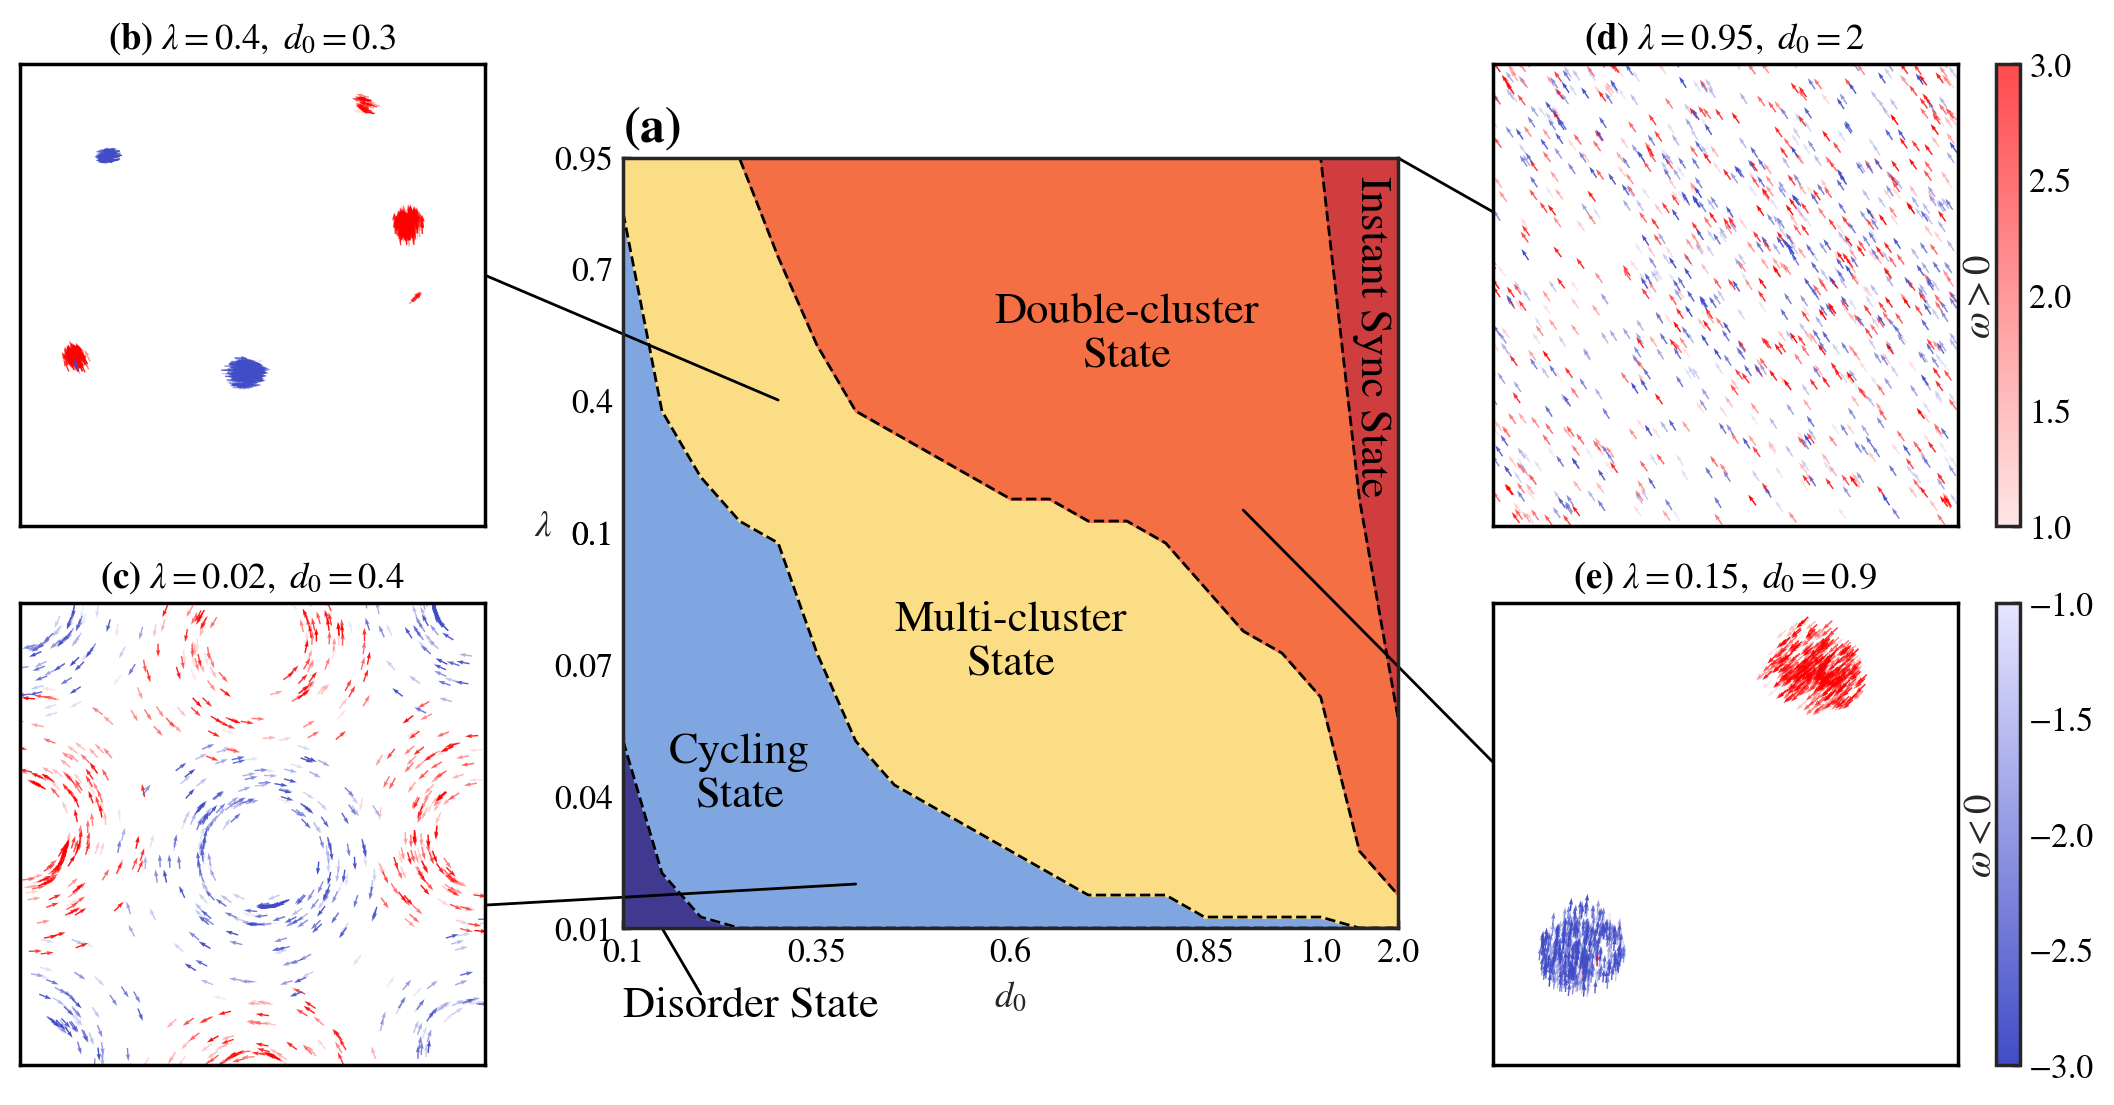

In [57]:
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c1],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), 0, funcIdxs[lambda_c1], alpha=1, color="#403990"
)
plt.text(0, -4, "Disorder State", fontsize=16, color="black", rotation=0)
ax.plot([2, 1], [-3, 0], clip_on=False, color="black", lw=1)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c2],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c1], funcIdxs[lambda_c2], alpha=1, color="#80A6E2"
)
plt.text(3, 7, "Cycling\nState", ha="center", va="center", fontsize=16, color="black")
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c3],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c2], funcIdxs[lambda_c3], alpha=1, color="#FBDD85"
)
plt.text(10, 13, "Multi-cluster\nState", ha="center", va="center", fontsize=16, color="black")
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c4],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c3], funcIdxs[lambda_c4], alpha=1, color="#F46F43"
)
plt.text(13, 27, "Double-cluster\nState", ha="center", va="center", fontsize=16, color="black")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c4], 35, alpha=1, color="#CF3D3E"
)
plt.text(18.8, 20, "Instant Sync State", fontsize=16, color="Black", rotation=-90)
xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.tick_params(direction='in', length=3)

plt.xlim(0, 20)
plt.ylim(0, 35)
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.grid(False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axSwarmM = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(-0.8, 0.5, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
ax.plot([-4, 4], [30, 24], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.4:.3f}_{0.3:.2f}", ax=axSwarmM)
axSwarmM.set_title(r"$\mathbf{(b)}\ \lambda=0.4,\ d_0=0.3$")

axRing = inset_axes(ax, width="40%", height="40%", loc='lower left',
                    bbox_to_anchor=(-0.8, -0.2, 1.5, 1.5),
                    bbox_transform=ax.transAxes)
ax.plot([-4, 6], [1, 2], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.02:.3f}_{0.4:.2f}", ax=axRing, loadModel=True, randomSeed=80)
axRing.set_title(r"$\mathbf{(c)}\ \lambda=0.02,\ d_0=0.4$")

axQuickSync = inset_axes(ax, width="40%", height="40%", loc='lower left',
                         bbox_to_anchor=(1.1, 0.5, 1.5, 1.5),
                         bbox_transform=ax.transAxes)
ax.plot([25, 20], [30, 35], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.95:.3f}_{2:.2f}", ax=axQuickSync)
axQuickSync.set_title(r"$\mathbf{(d)}\ \lambda=0.95,\ d_0=2$")

axSwarmD = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(1.1, -0.2, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
ax.plot([25, 16], [3, 19], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.15:.3f}_{0.9:.2f}", ax=axSwarmD)
axSwarmD.set_title(r"$\mathbf{(e)}\ \lambda=0.15,\ d_0=0.9$")

colorbarAx1 = inset_axes(ax, width="2%", height="40%", loc='lower left',
                        bbox_to_anchor=(1.75, 0.5, 1.5, 1.5),
                        bbox_transform=ax.transAxes)
alphaRate = 0.9
colors = ["#FFE6E6", "#FF4B4E"]
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
cbar = plt.colorbar(sca, cax=colorbarAx1)
cbar.set_label(r"$\omega>0$", fontsize=14, labelpad=-39)
cbar.ax.tick_params(direction='in', length=3)

colorbarAx2 = inset_axes(ax, width="2%", height="40%", loc='lower left',
                        bbox_to_anchor=(1.75, -0.2, 1.5, 1.5),
                        bbox_transform=ax.transAxes)
colors = ["#414CC7", "#E6E6FF"]
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=-np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
cbar = plt.colorbar(sca, cax=colorbarAx2)
cbar.set_label(r"$\omega<0$", fontsize=14, labelpad=-47)
cbar.ax.tick_params(direction='in', length=3)

ax.set_title(r"$\mathbf{(a)}$", loc="left", fontsize=18)
# 保存为矢量图
plt.savefig("./PJT_C_Fig/phaseDiagram.pdf", bbox_inches="tight")

### 聚类平均距离方差

In [ ]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    distances = StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    classes = StateAnalysis._calc_classes(centers, 1, distances)
    counts = 0
    sumR = 0
    for classOcsis in classes:
        # if len(classOcsis) < 5:
        #     continue
        classDis = distances[classOcsis]
        sumR += np.var(classDis[classDis != 0])
        counts += 1
    
    maps.loc[l, d0] = sumR / counts

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 聚类数

In [46]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 1, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    
    maps.loc[l, d0] = len(classes)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
cMaps = maps.copy()

### 中心距离倒数加权相位同步程度

In [ ]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    centerDisMat = 1 / np.sqrt(np.sum(deltaX ** 2, axis=-1))
    centerDisMat[np.isinf(centerDisMat)] = 0
    # rowWgtPhase = lastPhaseTheta * centerDisMat / centerDisMat.sum(axis=0)
    N = centers.shape[0]
    phaseSyncs = [
        (
            (np.sum(np.sin(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2 + 
            (np.sum(np.cos(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2
        )**0.5
        for rowIdx in range(N)
    ]
    maps.loc[l, d0] = np.mean(phaseSyncs)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

## 时序序参量

In [ ]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
### 旋转中心空间分布
plot_tvcp(models, savePath="./figs/egs/4.3.png")
### 旋转半径分布
plot_tvcr(models, savePath="./figs/egs/totalRadius.png")
### 旋转中心空间聚集程度1
plot_tvcaop(models, opType=1, savePath="./figs/egs/centerAggOp1_ts.png")
### 旋转中心空间聚集程度2
plot_tvcaop(models, opType=2, savePath="./figs/egs/centerAggOp2_ts.png")
### 旋转中心平均距离分布
plot_tvca(models, opType=1, savePath="./figs/egs/centerAgg1_ts.png")
### 中心距离倒数加权相位同步程度（各粒子）
plot_drpa(models, savePath="./figs/egs/weightedPhaseSync_ts.png")
### 中心距离倒数加权相位同步程度（算数平均）
plot_drpaop(models, savePath="./figs/egs/weightedPhaseSyncOp_ts.png")
### 旋转中心邻域内相位同步程度 (各粒子)
plot_ldpa(models, savePath="./figs/egs/limitDisPhaseSync_ts.png")
### 旋转中心邻域内相位同步程度 (算数平均)
plot_ldpaop(models, savePath="./figs/egs/limitDisPhaseSyncOp_ts.png")
### 聚类数
plot_ccop(models, savePath="./figs/egs/classCountsOp.png")
### 旋转中心邻域内中心数（各粒子）
plot_cnc(models, savePath="./figs/egs/centerNearbyCounts.png")
### 旋转中心邻域内中心数（算数平均）
plot_cncop(models, savePath="./figs/egs/centerNearbyCountsOp.png")

## 相位单位圆

In [3]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1)
])
models = [
    SpatialGroups(strengthLambda=l, distanceD0=1, dt=0.01, tqdm=False, savePath="./data") for l in rangeLambdas
]

./data/CorrectCoupling_uniform_0.900_2.00_10.h5


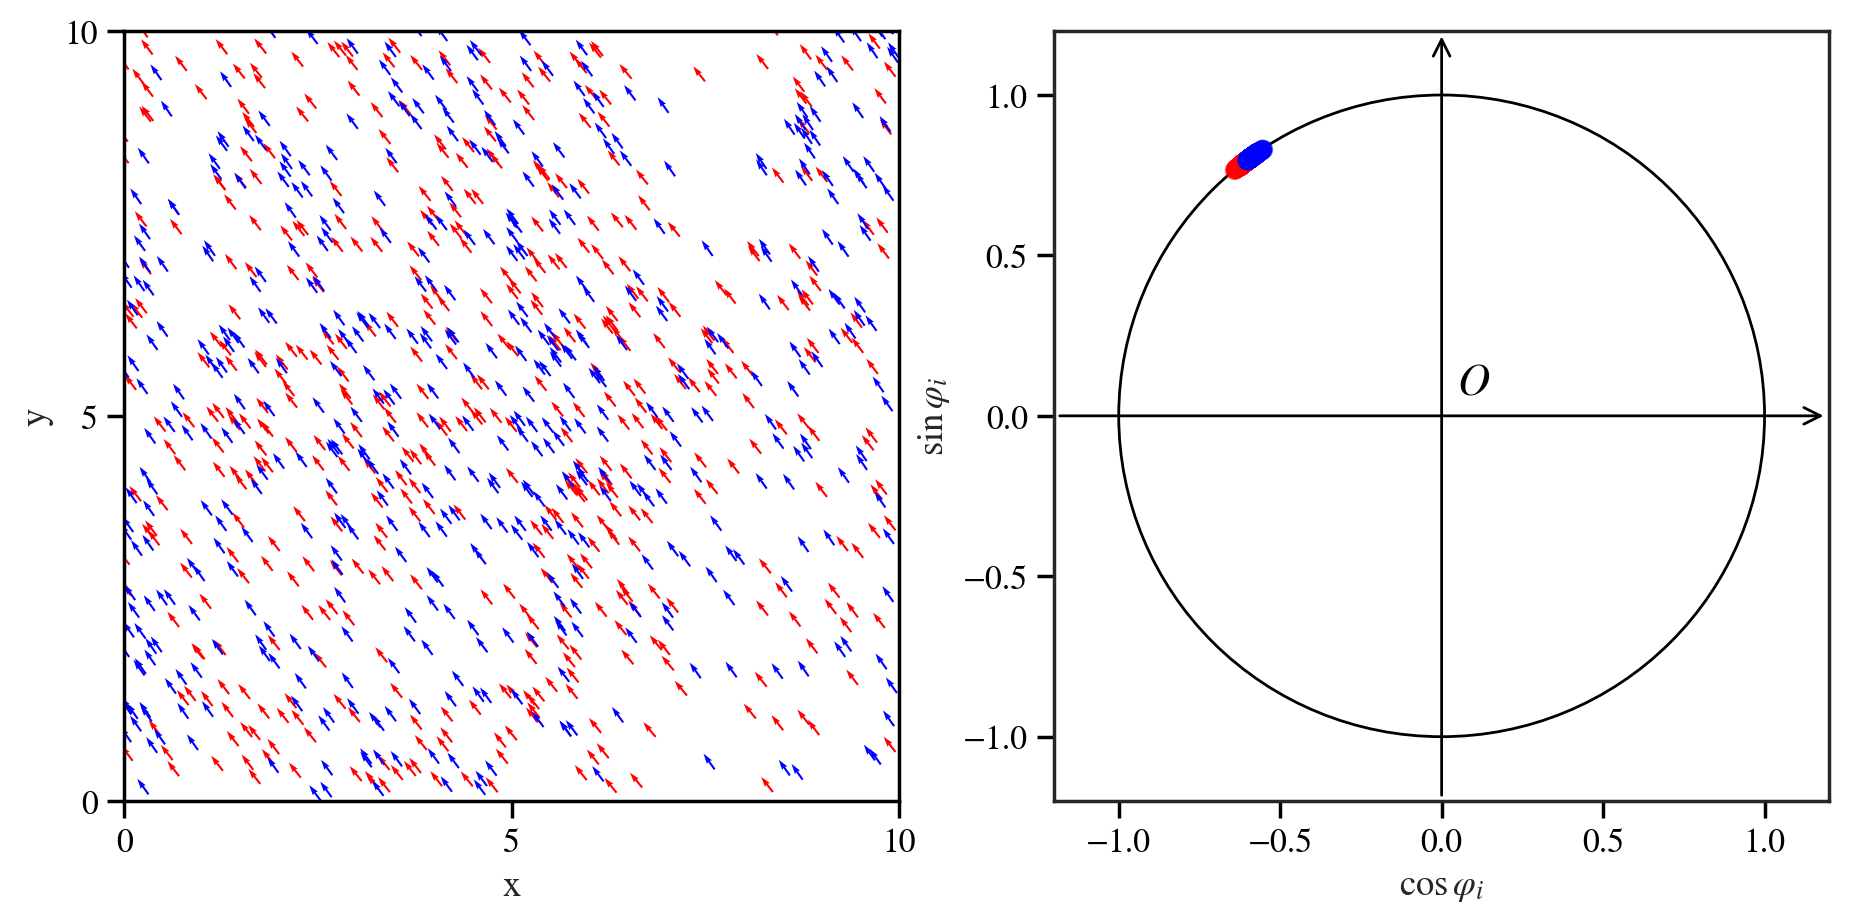

In [4]:
import matplotlib.patches as patches
model = SpatialGroups(strengthLambda=0.01, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

def plot_last(model):

    targetPath = f"./data/{model}.h5"
    print(targetPath)
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    idx = -76
    positionX = totalPositionX[idx]
    phaseTheta = totalPhaseTheta[idx]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='red'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='blue'
    )
    ax1.spines['bottom'].set_color('black')
    ax1.spines['top'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['right'].set_color('black')
    ax1.set_xticks([0, 5, 10])
    ax1.set_yticks([0, 5, 10])
    ax1.set_xlabel(r"x")
    ax1.set_ylabel(r"y")
    ax1.grid(False)
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    ax2.add_artist(circle)
    ax2.scatter(
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='red', alpha=0.5
    )
    ax2.scatter(
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='blue', alpha=0.5
    )
    lim = 1.2
    ax2.add_patch(patches.FancyArrowPatch(
        (0, -lim), (0, lim),
        color='black', arrowstyle='->', mutation_scale=15
    ))
    ax2.add_patch(patches.FancyArrowPatch(
        (-lim, 0), (lim, 0),
        color='black', arrowstyle='->', mutation_scale=15
    ))
    ax2.text(0.1, 0.1, r"$O$", ha="center", va="center", fontsize=16)
    
    ax2.set_xlim(-lim, lim)
    ax2.set_ylim(-lim, lim)
    ax2.grid(False)
    ax2.set_yticks([-1., -0.5, 0., 0.5, 1.])
    ax2.set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax2.set_xlabel(r"$\cos\varphi_i$")
    ax2.set_ylabel(r"$\sin\varphi_i$")

    plt.savefig(f"./figs/unitCircle/{model}_2d_circle.png", dpi=200)
    plt.show()

models = [
    # SpatialGroups(strengthLambda=0.3, distanceD0=2, savePath="./data", uniform=True, randomSeed=10),
    SpatialGroups(strengthLambda=0.9, distanceD0=2, savePath="./data", uniform=True, randomSeed=10),
    # SpatialGroups(strengthLambda=0.5, distanceD0=0.1, savePath="./data", uniform=True, randomSeed=10),
    # SpatialGroups(strengthLambda=0.009, distanceD0=2, savePath="./data", uniform=True, randomSeed=10),
    # SpatialGroups(strengthLambda=0.01, distanceD0=0.1, savePath="./data", uniform=True, randomSeed=10),
]

for model in models:
    plot_last(model)

In [ ]:
shift = 0

def plot_last(key: str):

    l, d0 = key.split("_")
    l, d0 = float(l), float(d0)
    model = SpatialGroups(strengthLambda=l, distanceD0=d0, dt=0.01, tqdm=False)

    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    lastPositionX = positionX[key]
    lastPhaseTheta = phaseTheta[key]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        lastPositionX[class1, 0], lastPositionX[class1, 1],
        np.cos(lastPhaseTheta[class1]), np.sin(lastPhaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        lastPositionX[class2, 0], lastPositionX[class2, 1],
        np.cos(lastPhaseTheta[class2]), np.sin(lastPhaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2, projection='3d')
    hist, bins = np.histogram(lastPhaseTheta[class1], bins=100, range=(-np.pi, np.pi))
    # print(np.array([np.zeros_like(hist), hist]).shape)
    ax2.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]), 
        np.array([np.zeros_like(hist), hist]), 
        color='tomato', alpha=0.5, edgecolor="tomato"
    )
    hist, bins = np.histogram(lastPhaseTheta[class2], bins=100, range=(-np.pi, np.pi))
    ax2.plot_surface(
        np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
        np.array([np.zeros_like(hist), hist]), 
        color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
    )
    ax2.set_xlabel(r"$\cos(\theta_I)$")
    ax2.set_ylabel(r"$\sin(\theta_I)$")

    plt.savefig(f"./figs/unitCircle/{model}.eps", dpi=250)
    plt.close()

for key in tqdm(positionX.keys()):
    plot_last(key)

In [ ]:
@nb.njit
def _delta_x(positionX, others):
    subX = positionX - others
    adjustOthers = (
        others * (-5 <= subX) * (subX <= 5) + 
        (others - 10) * (subX < -5) + 
        (others + 10) * (subX > 5)
    )
    adjustSubX = positionX - adjustOthers
    return adjustSubX

class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

def plot_last(model):

    sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
    positionX, phaseTheta, _ = sa.get_state()
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    fig, ax = plt.subplots(figsize=(11, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    centers = sa.centers
    deltaX = _delta_x(positionX, centers)
    radius = np.sqrt(np.sum(deltaX ** 2, axis=-1))
    omega1 = np.abs(model.omegaTheta[class1])
    omega2 = np.abs(model.omegaTheta[class2])
    omegaIdx = np.concatenate([np.argsort(omega1), np.argsort(omega2) + 500])
    
    ax2 = plt.subplot(1, 2, 2)
    color = ["tomato"] * 500 + ["dodgerblue"] * 500
    ax2.scatter(
        x=np.arange(1, 1001), y=radius[omegaIdx], color=color, s=1
    )
    # ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(0, 7)

    plt.savefig(f"./figs/{model}_radius.png", dpi=200)
    plt.show()

models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]

for model in models:
    plot_last(model)

In [14]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.9, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=80, overWrite=False),
]

In [ ]:
import matplotlib.pyplot as plt

model = SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
fig, axs = plt.subplots(1, 4, figsize=(24, 6.4))

# 创建子图
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]

ax1.tick_params(direction='in', length=3)

tickSize = 27
plot_last_state(f"{0.01:.3f}_{0.1:.2f}", ax=ax1, showTicks=True, tickSize=tickSize)

counts = 30
ax2.scatter(
    sa.totalPositionX[-100:, :counts, 0], sa.totalPositionX[-100:, :counts, 1], 
    s=0.1, alpha=1, color="#FF4B4E"
)
ax2.scatter(
    sa.totalPositionX[-100:, -counts:, 0], sa.totalPositionX[-100:, -counts:, 1], 
    s=0.1, alpha=1, color="#414CC7"
)

ax2.tick_params(direction='in', length=3)
ax2.set_xticks([0, 10], fontsize=tickSize)
ax2.set_yticks([0, 10], fontsize=tickSize)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.set_xlabel(r"$x$", fontsize=tickSize)
ax2.set_ylabel(r"$y$", fontsize=tickSize, rotation=0)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=tickSize)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=tickSize)
ax2.xaxis.labelpad = -20
ax2.yaxis.labelpad = -10

i = 2
for l, d0 in [
    [0.01, 0.75], [0.01, 0.95]
]:

    key = f"{l:.3f}_{d0:.2f}"
    loadModel = False if i == 2 else False

    plot_last_state(key, ax=axs[i], loadModel=loadModel, 
                    showTicks=True, tickSize=25, randomSeed=10)
    axs[i].tick_params(direction='in', length=3)
    i += 1

for ax in axs:
    ax.spines['top'].set_linewidth(3)    # 顶边界线
    ax.spines['bottom'].set_linewidth(3) # 底边界线
    ax.spines['left'].set_linewidth(3)   # 左边界线
    ax.spines['right'].set_linewidth(3)  # 右边界线

titleSize = 30
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=titleSize)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=titleSize)
ax3.set_title("(c)", loc="left", fontweight='bold', fontsize=titleSize)
ax4.set_title("(d)", loc="left", fontweight='bold', fontsize=titleSize)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/appendSnapshots.pdf", bbox_inches="tight")

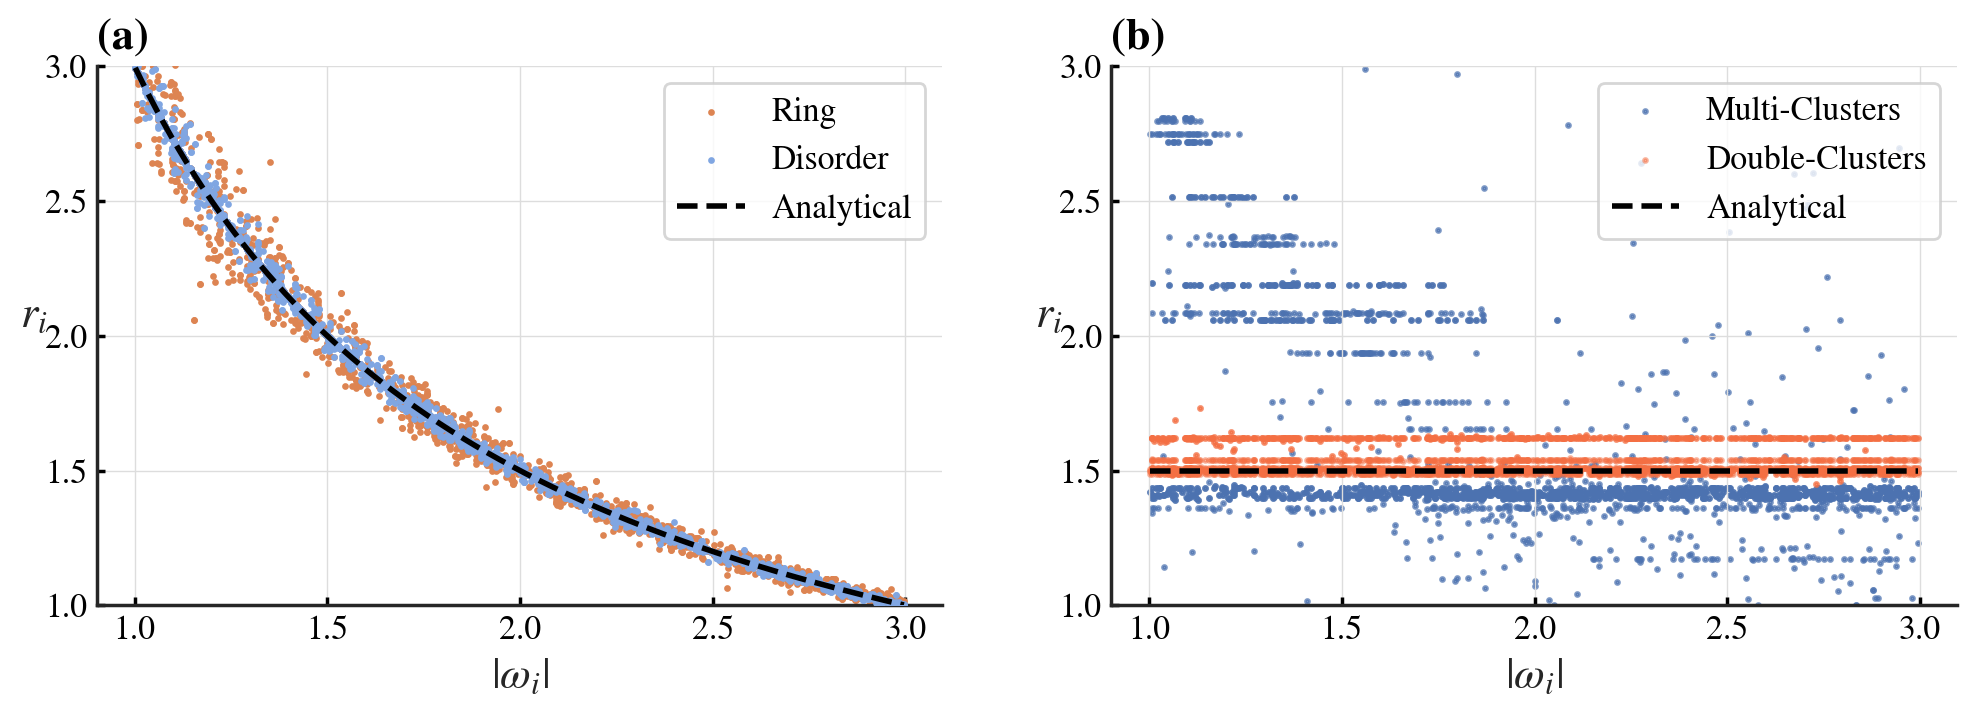

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))
tickSize = 16

ax1 = axs[0]

rangeLambdas = np.concatenate([
    np.arange(0.06, 0.1, 0.01)
])
distanceDs = [0.1]

for rangeLambda in rangeLambdas:
    
    model = SpatialGroups(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=10, 
                          tqdm=False, savePath="./data",
                          randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax1.scatter(omegaTheta, distances, s=2, color="C1", zorder=2)
    if rangeLambda == rangeLambdas[-1]:
        # legend = False
        # ax1.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Analytical")
        ax1.scatter(omegaTheta, distances, label="Ring", s=2, color="C1", zorder=2)
        ax1.legend(frameon=True, facecolor="white")

rangeLambdas = np.concatenate([
    np.arange(0.01, 0.06, 0.01)
])
distanceDs = [0.1]

for rangeLambda in rangeLambdas:
    
    model = SpatialGroups(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax1.scatter(omegaTheta, distances, s=2, color="#80A6E2", zorder=3)
    if rangeLambda == rangeLambdas[-1]:
        ax1.scatter(omegaTheta, distances, label="Disorder", s=2, color="#80A6E2", zorder=0)
        ax1.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=2, label="Analytical", zorder=3)
        ax1.legend(frameon=True, facecolor="white")

ax1.set_ylim(1, 3)
ax1.set_yticks([1, 1.5, 2, 2.5, 3])
ax1.set_xticks([1, 1.5, 2, 2.5, 3])
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.grid(True)
ax1.set_ylabel(r"$r_i$", fontsize=tickSize, rotation=0)
ax1.set_xlabel(r"$\left| \omega_i \right|$", fontsize=tickSize)

ax2 = axs[1]

rangeLambdas = [0.95]
distanceDs = np.arange(0.15, 0.25, 0.05)

for d0 in distanceDs:
    
    model = SpatialGroups(strengthLambda=0.95, distanceD0=d0, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax2.scatter(omegaTheta, distances, s=2, color="C0", zorder=0, alpha=0.7)
    if d0 == distanceDs[-1]:
        ax2.scatter(omegaTheta, distances, label="Multi-Clusters", s=2, color="C0", zorder=0, alpha=0.7)
        ax2.legend(frameon=True, facecolor="white")

rangeLambdas = np.concatenate([
    np.arange(0.02, 0.05, 0.01)
])
distanceDs = [2]

for rangeLambda in rangeLambdas:
    
    model = SpatialGroups(strengthLambda=rangeLambda, distanceD0=2, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax2.scatter(omegaTheta, distances, s=2, color="#F46F43", zorder=2, alpha=0.5)
    if rangeLambda == rangeLambdas[-1]:
        # legend = False
        ax2.scatter(omegaTheta, distances, label="Double-Clusters", s=2, color="#F46F43", zorder=2, alpha=0.5)
        ax2.plot(omegaTheta, 1.5 * np.ones_like(omegaTheta), linestyle="--", color="black", lw=2, label="Analytical", zorder=3)
        ax2.legend(frameon=True, facecolor="white", loc="upper right")


ax2.set_ylim(1, 3)
ax2.set_yticks([1, 1.5, 2, 2.5, 3])
ax2.set_xticks([1, 1.5, 2, 2.5, 3])
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.grid(True)
ax2.set_ylabel(r"$r_i$", fontsize=tickSize, rotation=0)
ax2.set_xlabel(r"$\left| \omega_i \right|$", fontsize=tickSize)

ax1.tick_params(direction='in', length=3)
ax2.tick_params(direction='in', length=3)
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=tickSize)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=tickSize)

# plt.tight_layout()
plt.savefig("./PJT_C_Fig/radiusOmega.png", bbox_inches="tight", dpi=300)

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


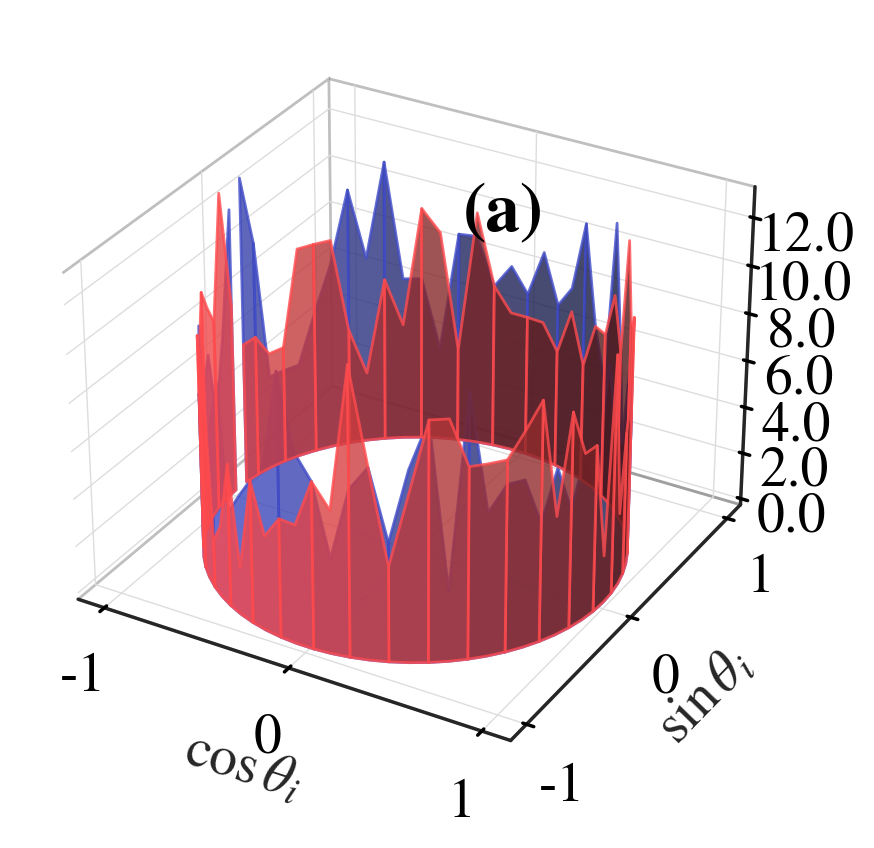

In [89]:
def plot_phase_unit(key: str, ax: plt.Axes, title: str = None, fontsize: int = 20):
    if ax is None:
        ax = plt.figure(figsize=(5, 5)).add_subplot(111, projection='3d')
    lastPhaseTheta = phaseTheta[key]
    hist1, bins = np.histogram(lastPhaseTheta[class1], bins=70, range=(-np.pi, np.pi))
    # print(np.array([np.zeros_like(hist), hist]).shape)
    ax.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]), 
        np.array([np.zeros_like(hist1), hist1]), 
        color='#FF4B4E', alpha=0.8, edgecolor="#FF4B4E"
    )
    hist2, bins = np.histogram(lastPhaseTheta[class2], bins=70, range=(-np.pi, np.pi))
    ax.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]),
        np.array([np.zeros_like(hist2), hist2]), 
        color='#414CC7', alpha=0.8, edgecolor="#414CC7"
    )
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_xlabel(r"$\cos\theta_i$", fontsize=fontsize)
    ax.set_ylabel(r"$\sin\theta_i$", fontsize=fontsize)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    # 设置ticks的字体大小
    ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize)
    ax.set_zticklabels(ax.get_zticks(), fontsize=fontsize)
    if title is not None:    
        ax.text(1, -1, max(max(hist1), max(hist2)) * 1.5, title, ha="center", va="center", fontsize=25, fontweight='bold')


plot_phase_unit(f"{0.01:.3f}_{0.1:.2f}", None, title="(a)")

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  


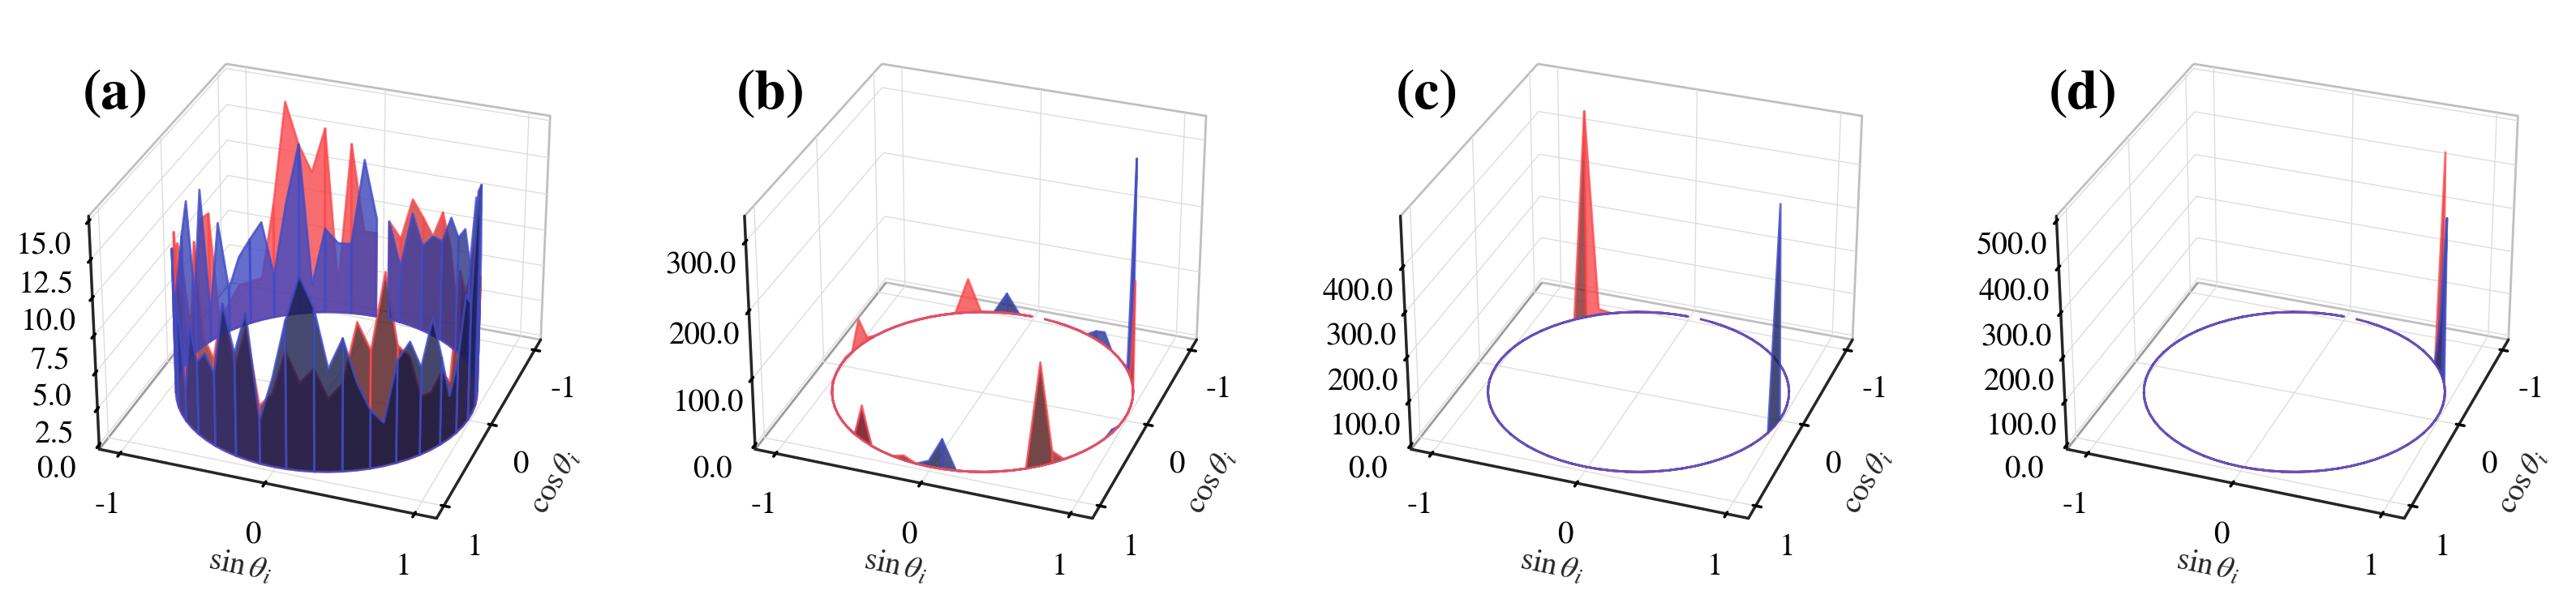

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': '3d'})

keys = [
    f"{0.015:.3f}_{0.35:.2f}",
    f"{0.8:.3f}_{0.2:.2f}",
    f"{0.15:.3f}_{0.9:.2f}",
    f"{0.95:.3f}_{2:.2f}",
]

for i, key in enumerate(keys):
    plot_phase_unit(key, ax[i], title=f"({chr(97 + i)})", fontsize=14)
    # 缩短title与图的距离

plt.tight_layout()
for i in range(4):
    ax[i].view_init(30, 20)

plt.savefig("./PJT_C_Fig/phaseHist.pdf", bbox_inches="tight")

In [4]:
# maps1 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)
# for l, d0 in product(rangeLambdas, distanceDs):

#     lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
#     lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
#     lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

#     phaseAggOp = StateAnalysis._clac_phase_sync_op(lastPhaseTheta)
#     maps1.loc[l, d0] = phaseAggOp
# maps1.index = np.round(maps1.index, 4)
# maps1.columns = np.round(maps1.columns, 4)

# maps2 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)
# for l, d0 in product(rangeLambdas, distanceDs):
#     lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
#     lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
#     lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

#     centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
#     centers = np.mod(centers, 10)
#     classes = StateAnalysis._calc_classes(
#         centers, 0.3, 
#         StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
#     )
#     counts = 0
#     sumR = 0
#     for classOcsis in classes:
#         if len(classOcsis) <= 5:
#             continue
#         sumR += StateAnalysis._clac_phase_sync_op(lastPhaseTheta[classOcsis])
#         counts += 1
    
#     maps2.loc[l, d0] = sumR / counts
# maps2.index = np.round(maps2.index, 4)
# maps2.columns = np.round(maps2.columns, 4)

maps1 = pd.read_csv("mean_R_step10.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps1.index = maps1.index.astype(float)
maps1.columns = maps1.columns.astype(float)

maps2 = pd.read_csv("mean_Rc_step10.csv", index_col=0)
maps2.index = maps2.index.astype(float)
maps2.columns = maps2.columns.astype(float)

maps3 = pd.read_csv("clusterDeltaOmega2.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps3.index = maps3.index.astype(float)
maps3.columns = maps3.columns.astype(float)

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


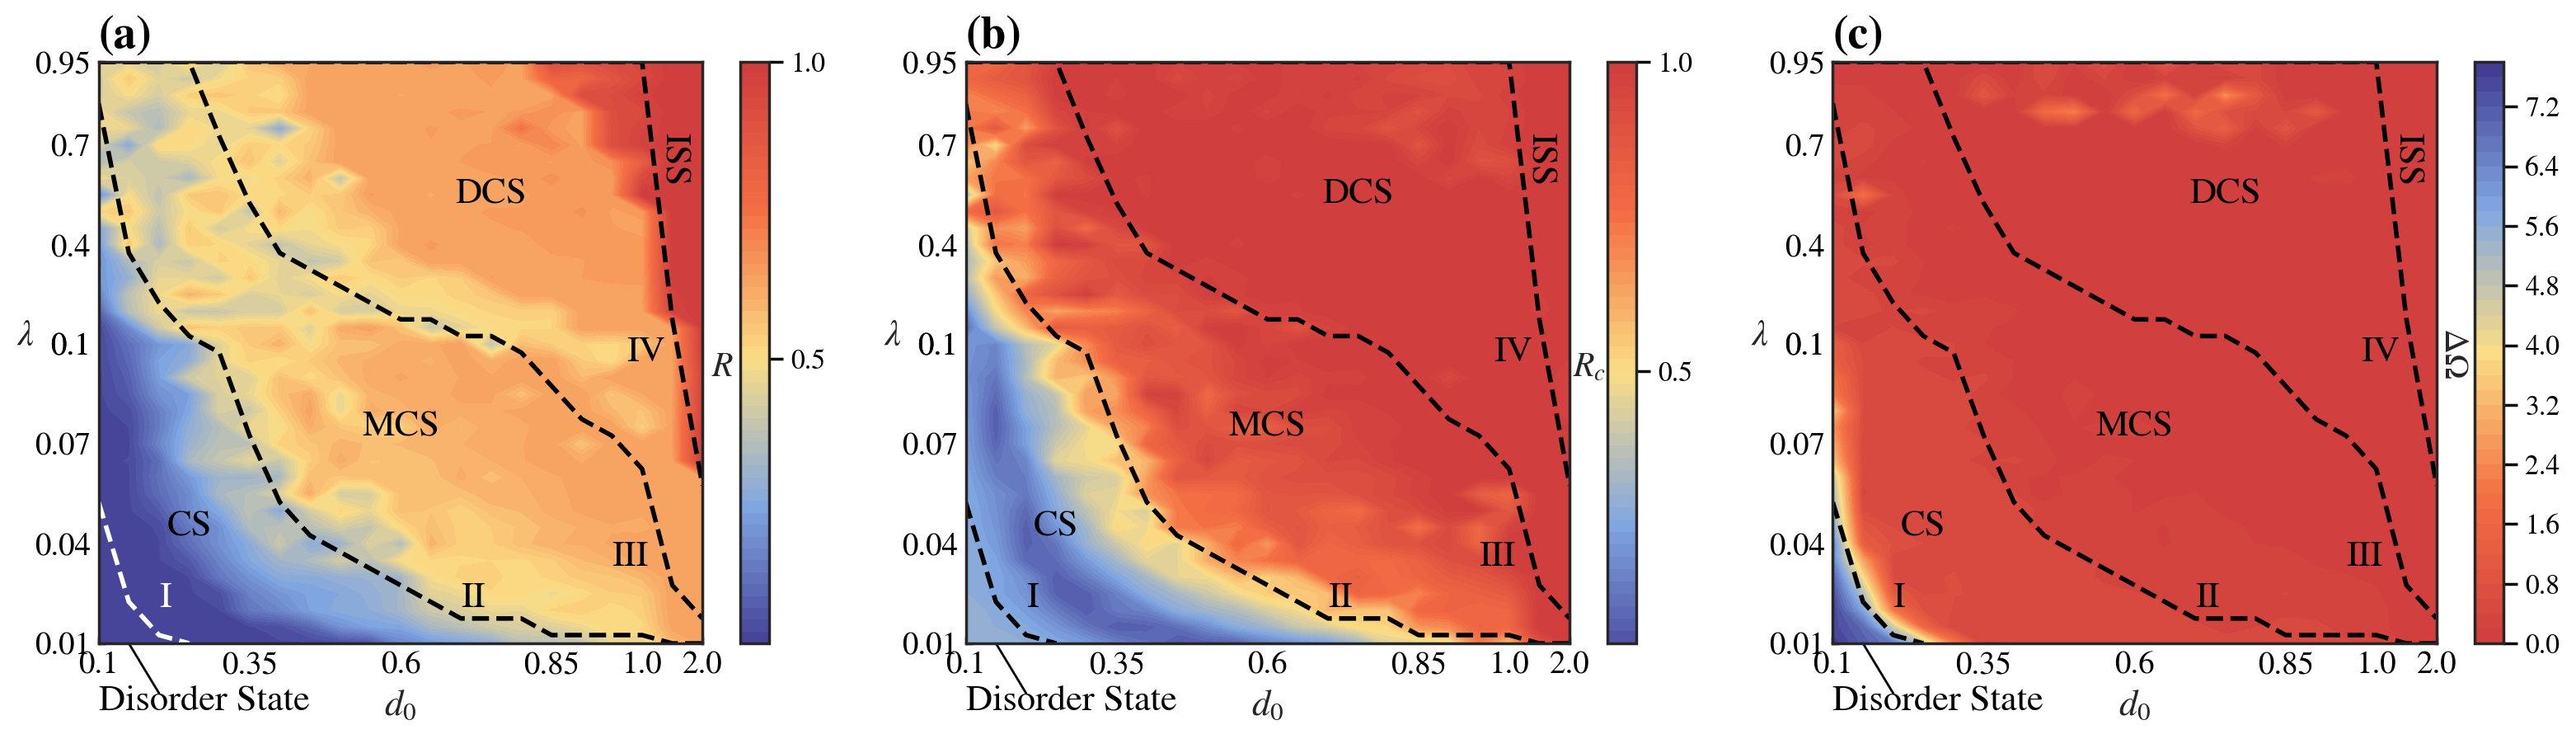

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4.7))
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

level = 50
# 不显示轮廓线
cf1 = ax[0].contourf(
    maps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar1 = plt.colorbar(cf1, ax=ax[0], ticks=[0, 0.5, 1])
cbar1.set_label(r"$R$", fontsize=15, rotation=0, labelpad=-45)
ax[0].plot(funcIdxs[lambda_c1][:4],
            linestyle="--", color="white", lw=2, zorder = 2)

cf2 = ax[1].contourf(
    maps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar2 = plt.colorbar(cf2, ax=ax[1], ticks=[np.min(maps2.values)-0.015, 0.5, 1])
cbar2.ax.set_yticklabels(['0.0', '0.5', '1.0'])
cbar2.set_label(r"$R_c$", fontsize=15, rotation=0, labelpad=-45)
ax[1].plot(funcIdxs[lambda_c1][:4],
            linestyle="--", color="black", lw=2, zorder = 2)


cf3 = ax[2].contourf(
    maps3, levels=level, 
    cmap=cmap_r,
)
cbar3 = plt.colorbar(cf3, ax=ax[2])
cbar3.set_label(r"$\Delta\Omega$", fontsize=15, rotation=-90, labelpad=-40)
ax[2].plot(funcIdxs[lambda_c1][:4],
            linestyle="--", color="black", lw=2, zorder = 2)

xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)

selectedColors = ["white", "black", "black"]
for i in range(3):
    ax[i].tick_params(direction='in', length=3)
    ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=14)
    ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=14)
    ax[i].set_xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
    ax[i].set_yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
    ax[i].set_xlabel(r"$d_0$", fontsize=16)
    ax[i].set_ylabel(r"$\lambda$", rotation=0, fontsize=16)
    ax[i].set_title(f"({chr(97 + i)})", loc="left", fontweight='bold', fontsize=20)
    ax[i].plot(np.arange(maps.shape[1]), funcIdxs[lambda_c2], label=r"$\lambda_{c2}(d_0)$",
            linestyle="--", color="black", lw=2, zorder = 2)
    ax[i].plot(np.arange(maps.shape[1]), funcIdxs[lambda_c3], label=r"$\lambda_{c3}(d_0)$",
            linestyle="--", color="black", lw=2, zorder = 2)
    ax[i].plot(np.arange(maps.shape[1]), funcIdxs[lambda_c4], label=r"$\lambda_{c4}(d_0)$",
            linestyle="--", color="black", lw=2, zorder = 2)
    ax[i].text(0, -4, "Disorder State", fontsize=16, color="black", rotation=0)
    ax[i].text(3, 7, "CS", ha="center", va="center", fontsize=16, color="black")
    ax[i].text(10, 13, "MCS", ha="center", va="center", fontsize=16, color="black")
    ax[i].text(13, 27, "DCS", ha="center", va="center", fontsize=16, color="black")
    ax[i].text(18.5, 28, "ISS", fontsize=16, color="Black", rotation=-90)
    ax[i].text(2, 2.2, "I", fontsize=16, color=selectedColors[i])
    ax[i].text(12, 2.2, "II", fontsize=16, color="black")
    ax[i].text(17, 4.7, "III", fontsize=16, color="black")
    ax[i].text(17.5, 17, "IV", fontsize=16, color="black")
    ax[i].plot([2, 1], [-3, 0], clip_on=False, color="black", lw=1)
    ax[i].set_xlim(0, 20)
    ax[i].set_ylim(0, 35)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/orderParam.png", bbox_inches="tight", dpi=300)

In [ ]:
def filter_double_cluster(colume: pd.Series):
    colume = colume.copy()
    d0 = colume.name
    critical2 = maps.index[maps.index > lambda_c3(d0)].min()
    if np.isnan(critical2) or np.isnan(lower):
        return colume * np.nan
    critical2Idx = maps.index.get_loc(critical2)
    colume.iloc[:critical2Idx] = np.nan
    if d0 >= 1:
        colume = colume * np.nan
    colume.iloc[critical2Idx + 6:] = np.nan
    # colume.iloc[]
    return colume

meanCounts = []
for dis in tqdm(np.arange(0.15, 0.51, 0.05)):

    maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

    for l, d0 in product(rangeLambdas, distanceDs):

        lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
        lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
        lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

        centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
        centers = np.mod(centers, 10)
        classes = StateAnalysis._calc_classes(
            centers, dis, 
            StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
        )

        classes = [c for c in classes if len(c) > 10]
        
        maps.loc[l, d0] = len(classes)
        filteredMaps = maps.apply(filter_double_cluster)
        notNanCount = filteredMaps.count().sum()
    meanCounts.append(filteredMaps.sum().sum() / notNanCount)
    # meanCounts.append(filteredMaps.min().min())

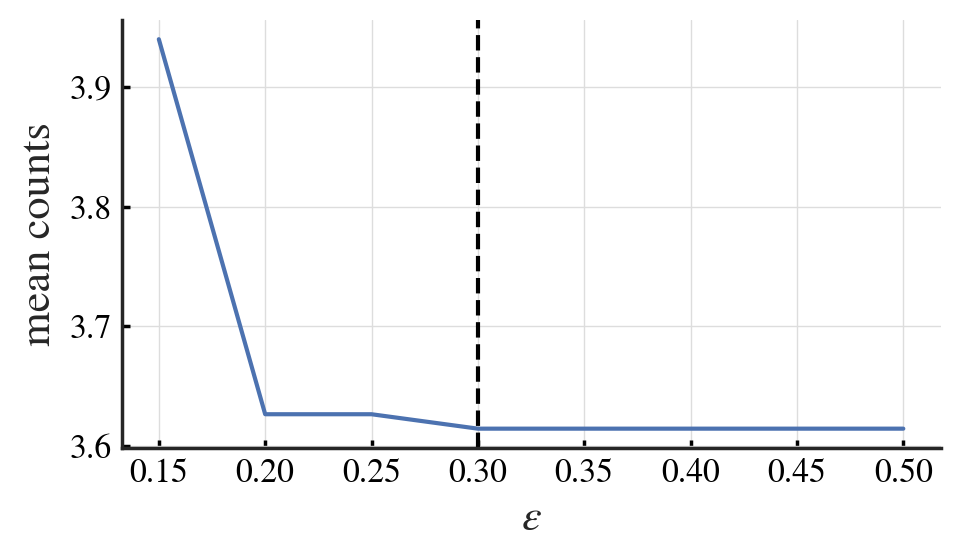

In [129]:
fig = plt.figure(figsize=(5, 3))

plt.plot(np.arange(0.15, 0.51, 0.05), meanCounts)
plt.xticks(np.arange(0.15, 0.51, 0.05))
plt.axvline(x=0.3, color='black', linestyle='--')
plt.xlabel(r"$\varepsilon$", fontsize=16)
plt.ylabel(r"mean counts", fontsize=16)
plt.tick_params(direction='in', length=3)
plt.grid(True)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.tight_layout()
plt.savefig("./PJT_C_Fig/DBSCANparam.pdf", bbox_inches="tight")

In [7]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    
    maps.loc[l, d0] = len(classes)

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


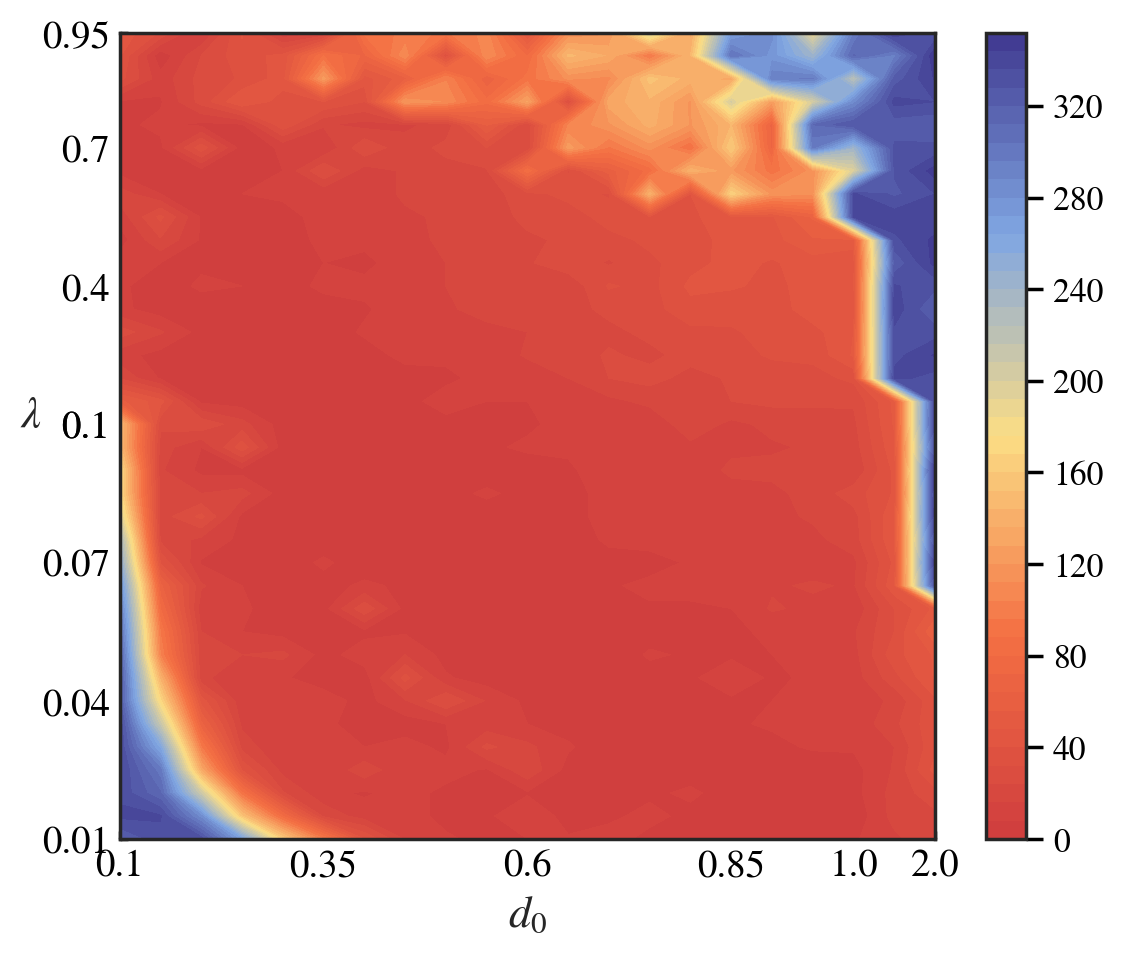

In [10]:
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cf = ax.contourf(
    maps, levels=50, cmap=cmap_r,
)
cbar = plt.colorbar(cf, ax=ax)
xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)
ax.tick_params(direction='in', length=3)
ax.set_xticklabels(ax.get_xticks(), fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
ax.set_yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
ax.set_xlabel(r"$d_0$", fontsize=16)
ax.set_ylabel(r"$\lambda$", rotation=0, fontsize=16)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/clusterCounts.png", bbox_inches="tight", dpi=300)

In [50]:
model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, dt=0.01, tqdm=False, 
                      savePath="./data", uniform=True, randomSeed=80, overWrite=False)
bsa = StateAnalysis(model, classDistance=0.3, lookIndex=-1, showTqdm=False)
classes1, centers = bsa.get_classes_centers()
singlePositionX, singlePhaseTheta, _ = bsa.get_state(-1)
idxs = np.concatenate(list(classes1.values()))
soredPosition = singlePositionX[idxs]
deltaX = SpatialGroups._delta_x(soredPosition, soredPosition[:, np.newaxis], 10, 5)
distances = SpatialGroups.distance_x(deltaX)
Aij1 = distances <= model.distanceD0

key = f"{0.15:.3f}_{0.9:.2f}"
lastPositionX = positionX[key]
lastPhaseTheta = phaseTheta[key]
lastPointTheta = pointTheta[key]
centers = StateAnalysis._calc_centers(
    lastPositionX, lastPhaseTheta, lastPointTheta, speedV, 0.01
)
classes = StateAnalysis._calc_classes(
    centers, 0.3, StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
)
classes2 = {i + 1: classes[i] for i in range(len(classes))}
idxs = np.concatenate(list(classes2.values()))
soredPosition = lastPositionX[idxs]
deltaX = SpatialGroups._delta_x(soredPosition, soredPosition[:, np.newaxis], 10, 5)
distances = SpatialGroups.distance_x(deltaX)
Aij2 = distances <= model.distanceD0

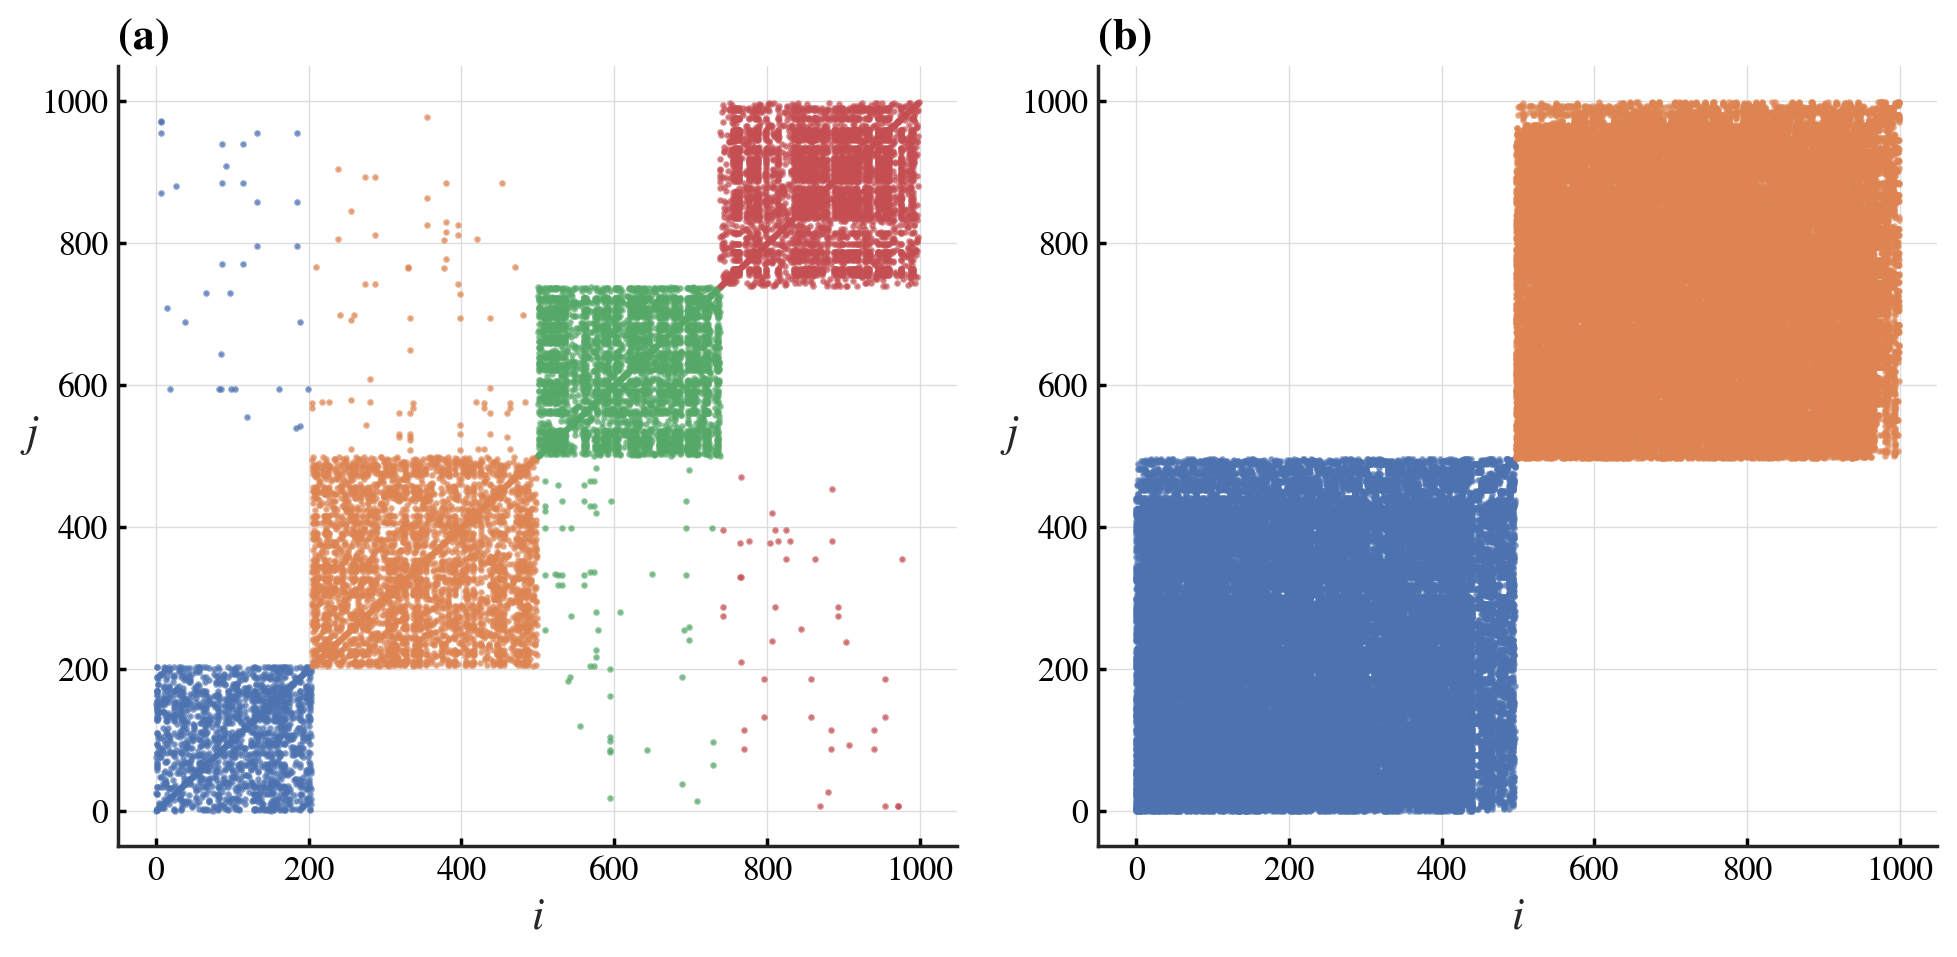

In [54]:
# clusterColors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
clusterColors = ["C0", "C1", "C2", "C3", "C4"]
colors1 = np.concatenate([[clusterColors[i - 1]] * len(classes1[i]) for i in range(1, len(classes1) + 1)])
colors2 = np.concatenate([[clusterColors[i - 1]] * len(classes2[i]) for i in range(1, len(classes2) + 1)])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axs

for idx, row in enumerate(Aij1):
    isTrue = np.where(row)[0]
    ax1.scatter(np.ones_like(isTrue) * idx, isTrue, color=colors1[idx], s=2, alpha=0.6)
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=16)

for idx, row in enumerate(Aij2):
    isTrue = np.where(row)[0]
    ax2.scatter(np.ones_like(isTrue) * idx, isTrue, color=colors2[idx], s=2, alpha=0.6)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=16)

for ax in axs:
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(r"$i$", fontsize=16)
    ax.set_ylabel(r"$j$", fontsize=16, rotation=0)
    ax.grid(True)

plt.tight_layout()

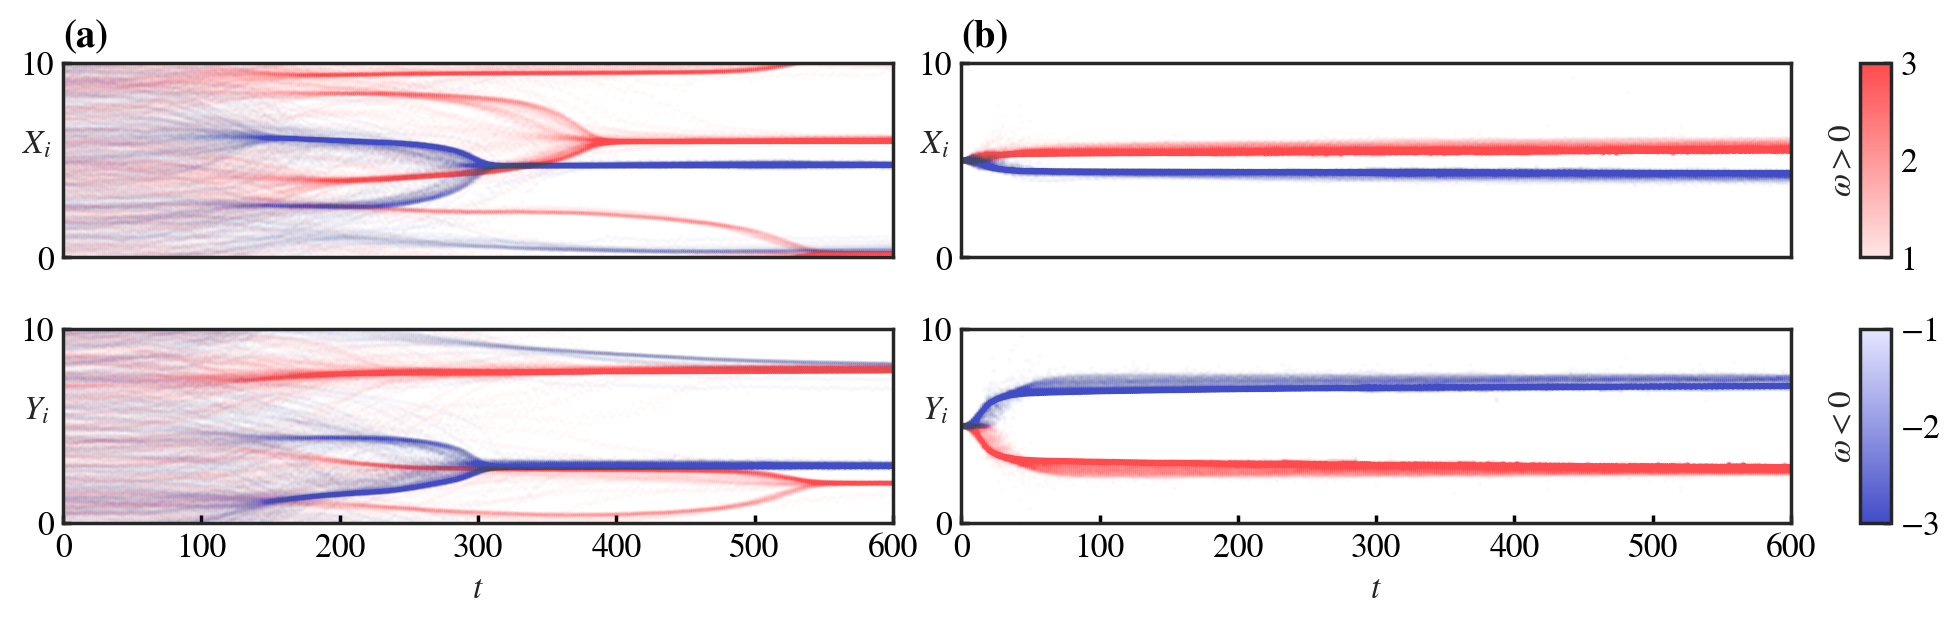

In [32]:
_ = plt.figure(figsize=(10, 5 / 3 * 2))

fontSize = 12

model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, 
                      savePath="./data", randomSeed=10)
colWide = 18
ax1Row1 = plt.subplot2grid((2, colWide + 1), (0, 0), colspan=colWide // 2)
ax1Row2 = plt.subplot2grid((2, colWide + 1), (1, 0), colspan=colWide // 2)
ax1Row1.tick_params(direction='in', length=3)
ax1Row2.tick_params(direction='in', length=3)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
cp1, _ = sa.tv_center_position(step=30)
cp1[:, 0] = cp1[:, 0]
color = ["#FF4B4E"] * 500 + ["#414CC7"] * 500
colors = np.array(color * (cp1.shape[0] // 1000))

s = 0.5
alpha = 0.01
step = 2
dt = 0.01
labelpad = -6

np.random.seed(10)
omegaTheta = np.random.uniform(1, 3, size=500)

idx = np.arange(cp1.shape[0], step=step)
ax1Row1.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 1], s=s, alpha=alpha, c=colors[idx])  # 
ax1Row1.set_ylim(0, 10)
ax1Row1.set_xlim(0, 12000 * dt * 5)
ax1Row1.set_xticks([])
ax1Row1.set_ylabel(f"$X_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax1Row1.set_title("(a)", loc="left", fontweight='bold', fontsize=fontSize + 2)
ax1Row1.set_yticks([0, 10])
ax1Row2.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 2], s=s, alpha=alpha, c=colors[idx])  # 
ax1Row2.set_ylim(0, 10)
ax1Row2.set_xlim(0, 12000 * dt * 5)
ax1Row2.set_xlabel(f"$t$", fontsize=fontSize)
ax1Row2.set_ylabel(f"$Y_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax1Row2.set_yticks([0, 10])

model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, 
                      savePath="./data", randomSeed=20)
ax2Row1 = plt.subplot2grid((2, colWide + 1), (0, colWide // 2), colspan=colWide // 2)
ax2Row2 = plt.subplot2grid((2, colWide + 1), (1, colWide // 2), colspan=colWide // 2)
ax2Row1.tick_params(direction='in', length=3)
ax2Row2.tick_params(direction='in', length=3)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
cp1, _ = sa.tv_center_position(step=30)

color2 = "#77A4DE"
cp1[:, 0] = cp1[:, 0]

idx = np.arange(cp1.shape[0], step=step)
ax2Row1.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 1], s=s, alpha=alpha, c=colors[idx])  #
ax2Row1.set_ylim(0, 10)
ax2Row1.set_xlim(0, 12000 * dt * 5)
ax2Row1.set_xticks([])
ax2Row1.set_ylabel(f"$X_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax2Row1.set_title("(b)", loc="left", fontweight='bold', fontsize=fontSize + 2)
ax2Row1.set_yticks([0, 10])
sca = ax2Row2.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 2], s=s, alpha=alpha, c=colors[idx])  #
ax2Row2.set_ylim(0, 10)
ax2Row2.set_xlim(0, 12000 * dt * 5)
ax2Row2.set_xlabel(f"$t$", fontsize=fontSize)
ax2Row2.set_ylabel(f"$Y_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax2Row2.set_yticks([0, 10])

colors = ["#FFE6E6", "#FF4B4E"]
labelpad2 = -32
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax2Row1.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
colorbarAx1 = plt.subplot2grid((2, colWide + 1), (0, colWide))
cbar = plt.colorbar(sca, cax=colorbarAx1)
cbar.set_label(r"$\omega>0$", fontsize=12, labelpad=labelpad2)
cbar.ax.tick_params(direction='in', length=3)

colors = ["#414CC7", "#E6E6FF"]
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax2Row2.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=-np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
colorbarAx2 = plt.subplot2grid((2, colWide + 1), (1, colWide))
cbar = plt.colorbar(sca, cax=colorbarAx2)
cbar.set_label(r"$\omega<0$", fontsize=12, labelpad=labelpad2 - 8)
cbar.ax.tick_params(direction='in', length=3)

plt.tight_layout(w_pad=0)
plt.savefig("./PJT_C_Fig/centersPosition.png", bbox_inches="tight", dpi=200)

In [2]:
enhancedLambdas = np.linspace(0.01, 1, 60000)
model = CorrectCouplingAfter(
    strengthLambda=0.01, distanceD0=2, enhancedLambdas=enhancedLambdas,
    savePath="./data", randomSeed=10, tqdm=True, overWrite=True
)
model.run()

  0%|          | 0/60000 [00:00<?, ?it/s]